<a href="https://colab.research.google.com/github/1978Biswajit/MGC/blob/main/Music_Genre_Classification_Using_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Importing the required libraries**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
import warnings
import os
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pickle
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout, Flatten
from keras.layers import Input, Dense, LSTM, concatenate, Activation, MaxPooling1D
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import log_loss
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from random import randint
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout, BatchNormalization, Reshape
# !pip install tensorflow # install tensorflow
import tensorflow as tf # import tensorflow as tf
from tensorflow.keras.layers import LeakyReLU
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Dataset Exploration & Visualization of Different**

In [ ]:
print("The genres present in the dataset are:")
print(os.listdir("/content/drive/MyDrive/gen/genres_original"))

# Load and inspect audio file
y, sr = librosa.load("/content/drive/MyDrive/gen/genres_original/blues/blues.00000.wav")
print("Sound Array:", y)
print("Sample Rate (KHz) =", sr)

The genres present in the dataset are:
['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
Sound Array: [ 0.00732422  0.01660156  0.00762939 ... -0.05560303 -0.06106567
 -0.06417847]
Sample Rate (KHz) = 22050


# **Trim silence**

Text(0.5, 1.0, 'Waveform in Blues 0')

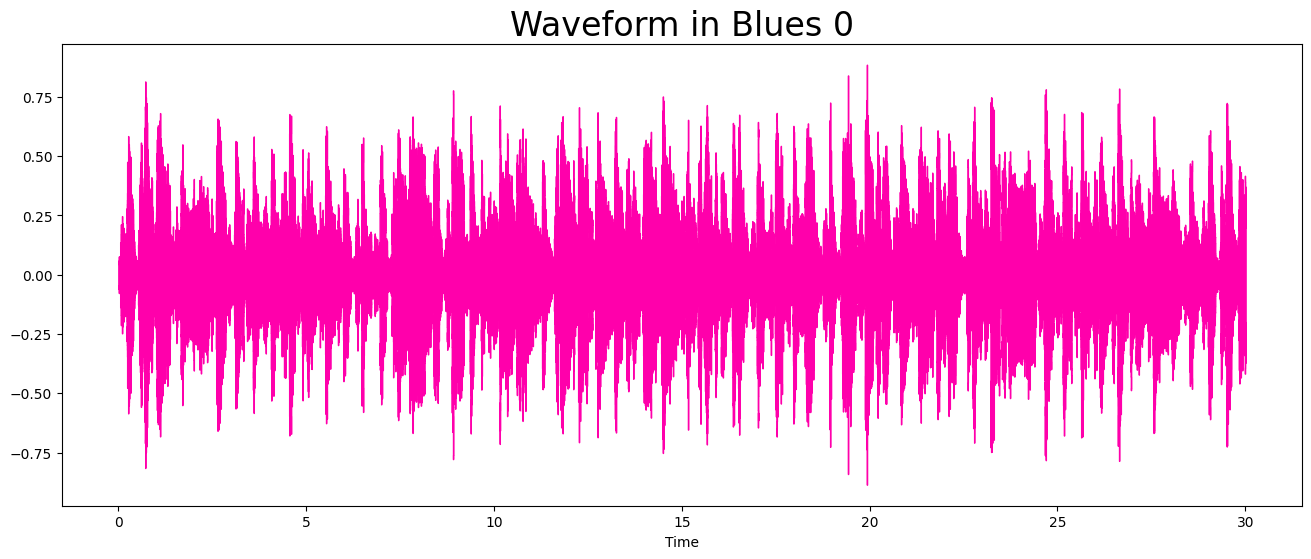

In [ ]:
# Trim silence
y, _ = librosa.effects.trim(y)

# Plot waveform
plt.figure(figsize=(16,6))
librosa.display.waveshow(y=y, sr=sr, color="#FF00AB")
plt.title("Waveform in Blues 0", fontsize=24)

## **Chroma Spectrogram**

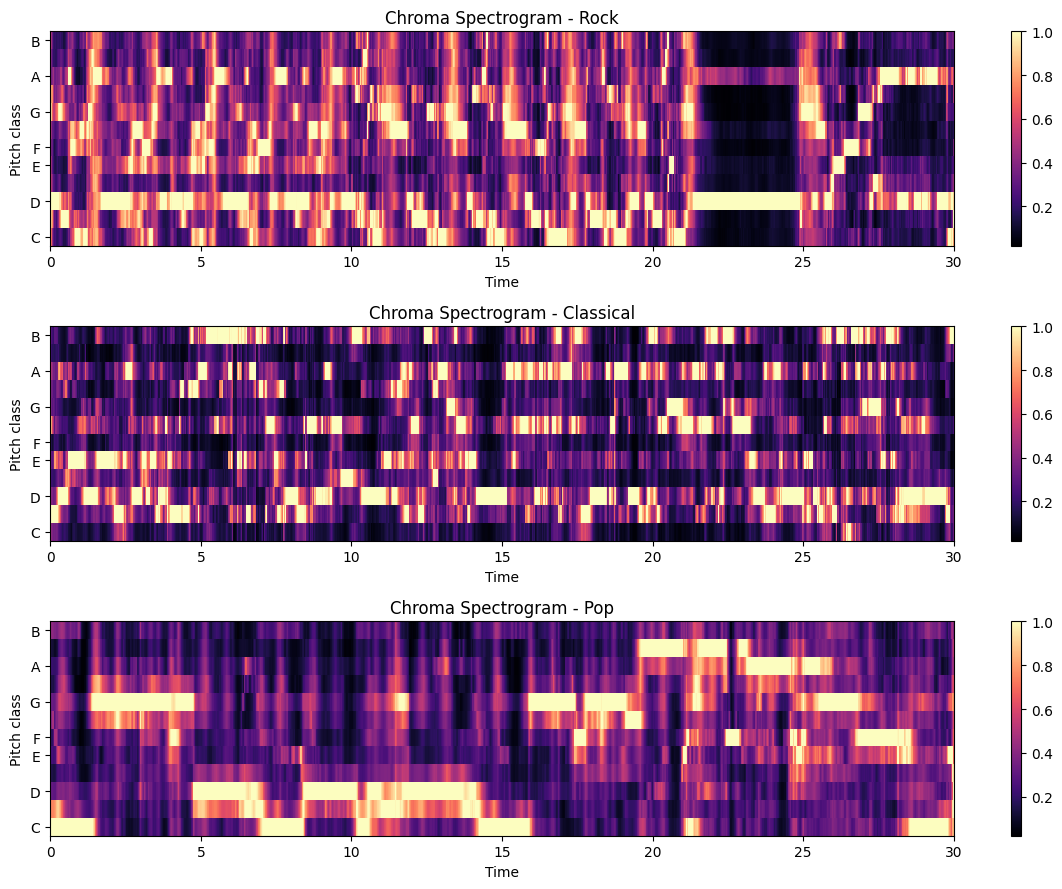

In [ ]:
rock, r_sr = libr osa.load("/content/drive/MyDrive/gen/genres_original/rock/rock.00000.wav")
classical, c_sr = librosa.load("/content/drive/MyDrive/gen/genres_original/classical/classical.00000.wav")
pop, p_sr = librosa.load("/content/drive/MyDrive/gen/genres_original/pop/pop.00000.wav")

chroma_rock = librosa.feature.chroma_cqt(y=rock, sr=r_sr)
chroma_cls = librosa.feature.chroma_cqt(y=classical, sr=c_sr)
chroma_pop = librosa.feature.chroma_cqt(y=pop, sr=p_sr)

plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
librosa.display.specshow(chroma_rock, sr=r_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Rock')
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(chroma_cls, sr=c_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Classical')
plt.colorbar()

plt.subplot(3, 1, 3)
librosa.display.specshow(chroma_pop, sr=p_sr, x_axis='time', y_axis='chroma')
plt.title('Chroma Spectrogram - Pop')
plt.colorbar()
plt.tight_layout()
plt.show()

## **Tempograms**

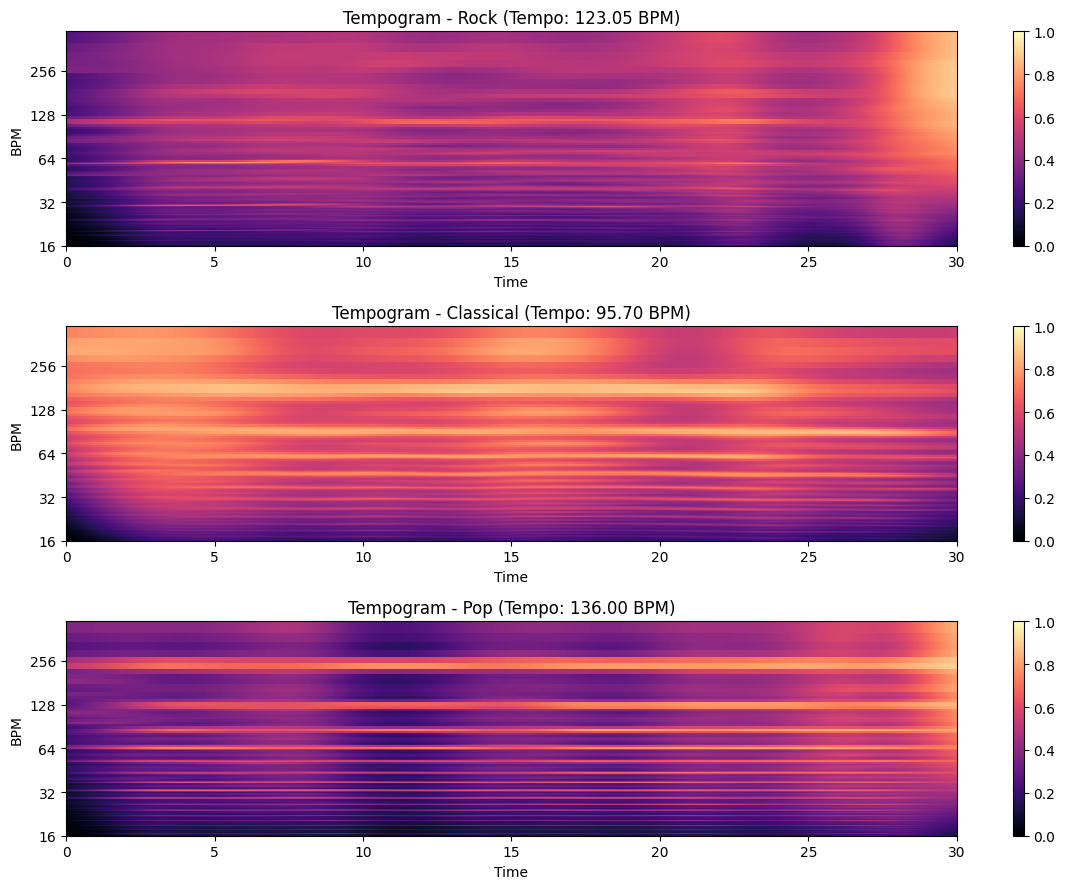

In [ ]:
tempo_rock = librosa.beat.tempo(y=rock, sr=r_sr)
tempogram_rock = librosa.feature.tempogram(y=rock, sr=r_sr, hop_length=512, win_length=384, window=np.hanning)
tempo_cls = librosa.beat.tempo(y=classical, sr=c_sr)
tempogram_cls = librosa.feature.tempogram(y=classical, sr=c_sr, hop_length=512, win_length=384, window=np.hanning)
tempo_pop = librosa.beat.tempo(y=pop, sr=p_sr)
tempogram_pop = librosa.feature.tempogram(y=pop, sr=p_sr, hop_length=512, win_length=384, window=np.hanning)

plt.figure(figsize=(12, 9))
plt.subplot(3, 1, 1)
librosa.display.specshow(tempogram_rock, sr=r_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Rock (Tempo: {:.2f} BPM)'.format(tempo_rock[0]))
plt.colorbar()

plt.subplot(3, 1, 2)
librosa.display.specshow(tempogram_cls, sr=c_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Classical (Tempo: {:.2f} BPM)'.format(tempo_cls[0]))
plt.colorbar()

plt.subplot(3, 1, 3)
librosa.display.specshow(tempogram_pop, sr=p_sr, hop_length=512, x_axis='time', y_axis='tempo')
plt.title('Tempogram - Pop (Tempo: {:.2f} BPM)'.format(tempo_pop[0]))
plt.colorbar()
plt.tight_layout()
plt.show()

## **Harmonics & Percussive**

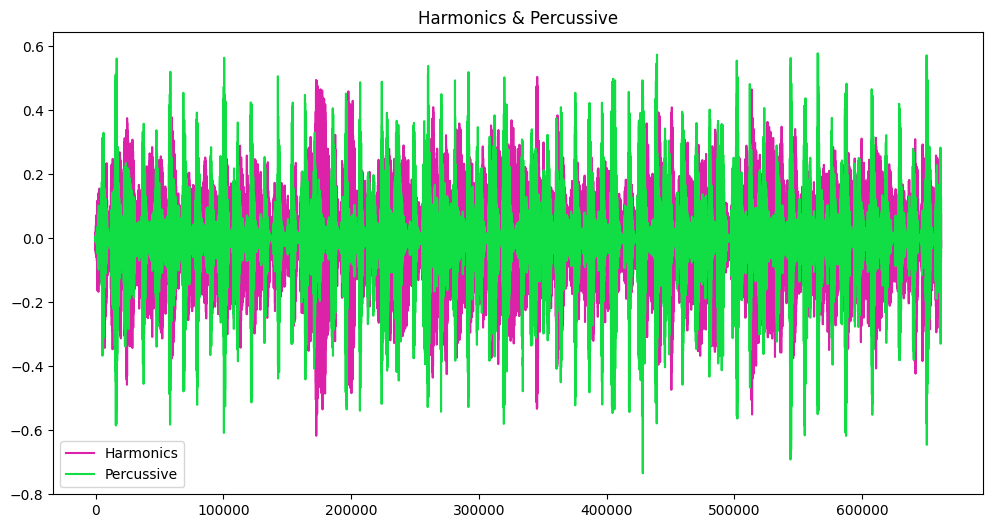

In [ ]:
y_harm, y_perc = librosa.effects.hpss(y)
plt.figure(figsize=(12, 6))
plt.plot(y_harm, color='#DD22AA', label='Harmonics')
plt.plot(y_perc, color='#11DD44', label='Percussive')
plt.title("Harmonics & Percussive")
plt.legend()
plt.show()

## **Data Shape**

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/gen/features_3_sec.csv")
print(data.shape)

(9990, 60)


## **Exploratory Data Analysis**

In [ ]:

data.head()

filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0  blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1  blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2  blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3  blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4  blues.00000.4.wav   66149          0.335579         0.088129  0.143289   

    rms_var  spectral_centroid_mean  spectral_centroid_var  \
0  0.003521             1773.065032          167541.630869   
1  0.001450             1816.693777           90525.690866   
2  0.004620             1788.539719          111407.437613   
3  0.002448             1655.289045          111952.284517   
4  0.001701             1630.656199           79667.267654   

   spectral_bandwidth_mean  spectral_bandwidth_var  ...  mfcc16_var  \
0              1972.744388           117335.771563  ...   39.687145   
1              2010.051501            65671.875673  ...   64.748276   
2              2084.565132            75124.921716  ...   67.336563   
3              1960.039988            82913.639269  ...   47.739452   
4              1948.503884            60204.020268  ...   30.336359   

   mfcc17_mean  mfcc17_var  mfcc18_mean  mfcc18_var  mfcc19_mean  mfcc19_var  \
0    -3.241280   36.488243     0.722209   38.099152    -5.050335   33.618073   
1    -6.055294   40.677654     0.159015   51.264091    -2.837699   97.030830   
2    -1.768610   28.348579     2.378768   45.717648    -1.938424   53.050835   
3    -3.841155   28.337118     1.218588   34.770935    -3.580352   50.836224   
4     0.664582   45.880913     1.689446   51.363583    -3.392489   26.738789   

   mfcc20_mean  mfcc20_var  label  
0    -0.243027   43.771767  blues  
1     5.784063   59.943081  blues  
2     2.517375   33.105122  blues  
3     3.630866   32.023678  blues  
4     0.536961   29.146694  blues  

[5 rows x 60 columns]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [ ]:
data.describe()

length  chroma_stft_mean  chroma_stft_var     rms_mean       rms_var  \
count   9990.0       9990.000000      9990.000000  9990.000000  9.990000e+03   
mean   66149.0          0.379534         0.084876     0.130859  2.676388e-03   
std        0.0          0.090466         0.009637     0.068545  3.585628e-03   
min    66149.0          0.107108         0.015345     0.000953  4.379535e-08   
25%    66149.0          0.315698         0.079833     0.083782  6.145900e-04   
50%    66149.0          0.384741         0.085108     0.121253  1.491318e-03   
75%    66149.0          0.442443         0.091092     0.176328  3.130862e-03   
max    66149.0          0.749481         0.120964     0.442567  3.261522e-02   

       spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
count             9990.000000           9.990000e+03              9990.000000   
mean              2199.219431           4.166727e+05              2241.385959   
std                751.860611           4.349644e+05               543.854449   
min                472.741636           8.118813e+02               499.162910   
25%               1630.680158           1.231961e+05              1887.455790   
50%               2208.628236           2.650692e+05              2230.575595   
75%               2712.581884           5.624152e+05              2588.340505   
max               5432.534406           4.794119e+06              3708.147554   

       spectral_bandwidth_var  rolloff_mean  ...  mfcc16_mean   mfcc16_var  \
count            9.990000e+03   9990.000000  ...  9990.000000  9990.000000   
mean             1.182711e+05   4566.076592  ...     1.448240    49.988755   
std              1.013505e+05   1642.065335  ...     5.735149    34.442816   
min              1.183520e+03    658.336276  ...   -26.850016     1.325786   
25%              4.876553e+04   3378.311110  ...    -2.227478    29.584894   
50%              8.996072e+04   4631.377892  ...     1.461623    41.702393   
75%              1.585674e+05   5591.634521  ...     5.149752    59.274619   
max              1.235143e+06   9487.446477  ...    39.144405   683.932556   

       mfcc17_mean   mfcc17_var  mfcc18_mean   mfcc18_var  mfcc19_mean  \
count  9990.000000  9990.000000  9990.000000  9990.000000  9990.000000   
mean     -4.198706    51.962753     0.739943    52.488851    -2.497306   
std       5.677379    36.400669     5.181313    38.177120     5.111799   
min     -27.809795     1.624544   -20.733809     3.437439   -27.448456   
25%      -7.951722    29.863448    -2.516638    29.636197    -5.734123   
50%      -4.443021    42.393583     0.733772    41.831377    -2.702366   
75%      -0.726945    61.676964     3.888734    62.033906     0.514246   
max      34.048843   529.363342    36.970322   629.729797    31.365425   

        mfcc19_var  mfcc20_mean   mfcc20_var  
count  9990.000000  9990.000000  9990.000000  
mean     54.973829    -0.917584    57.322614  
std      41.585677     5.253243    46.444212  
min       3.065302   -35.640659     0.282131  
25%      30.496412    -4.004475    30.011365  
50%      43.435253    -1.030939    44.332155  
75%      65.328602     2.216603    68.210421  
max    1143.230591    34.212101   910.473206  

[8 rows x 58 columns]

## **Box Plot of label vs tempo**

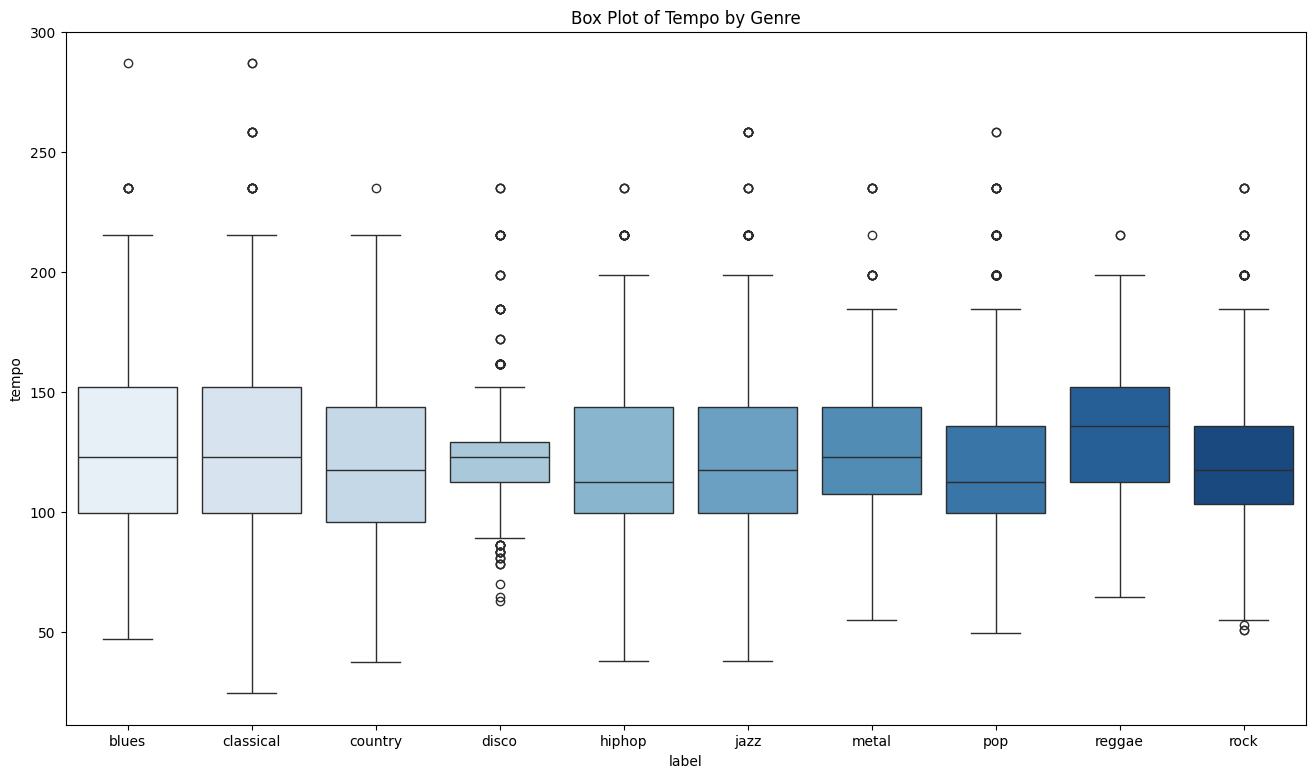

In [ ]:
plt.figure(figsize=(16, 9))
sns.boxplot(x="label", y="tempo", data=data, palette='Blues')
plt.title('Box Plot of Tempo by Genre')
plt.show()

## **Correlation Heatmap for Mean Variables**

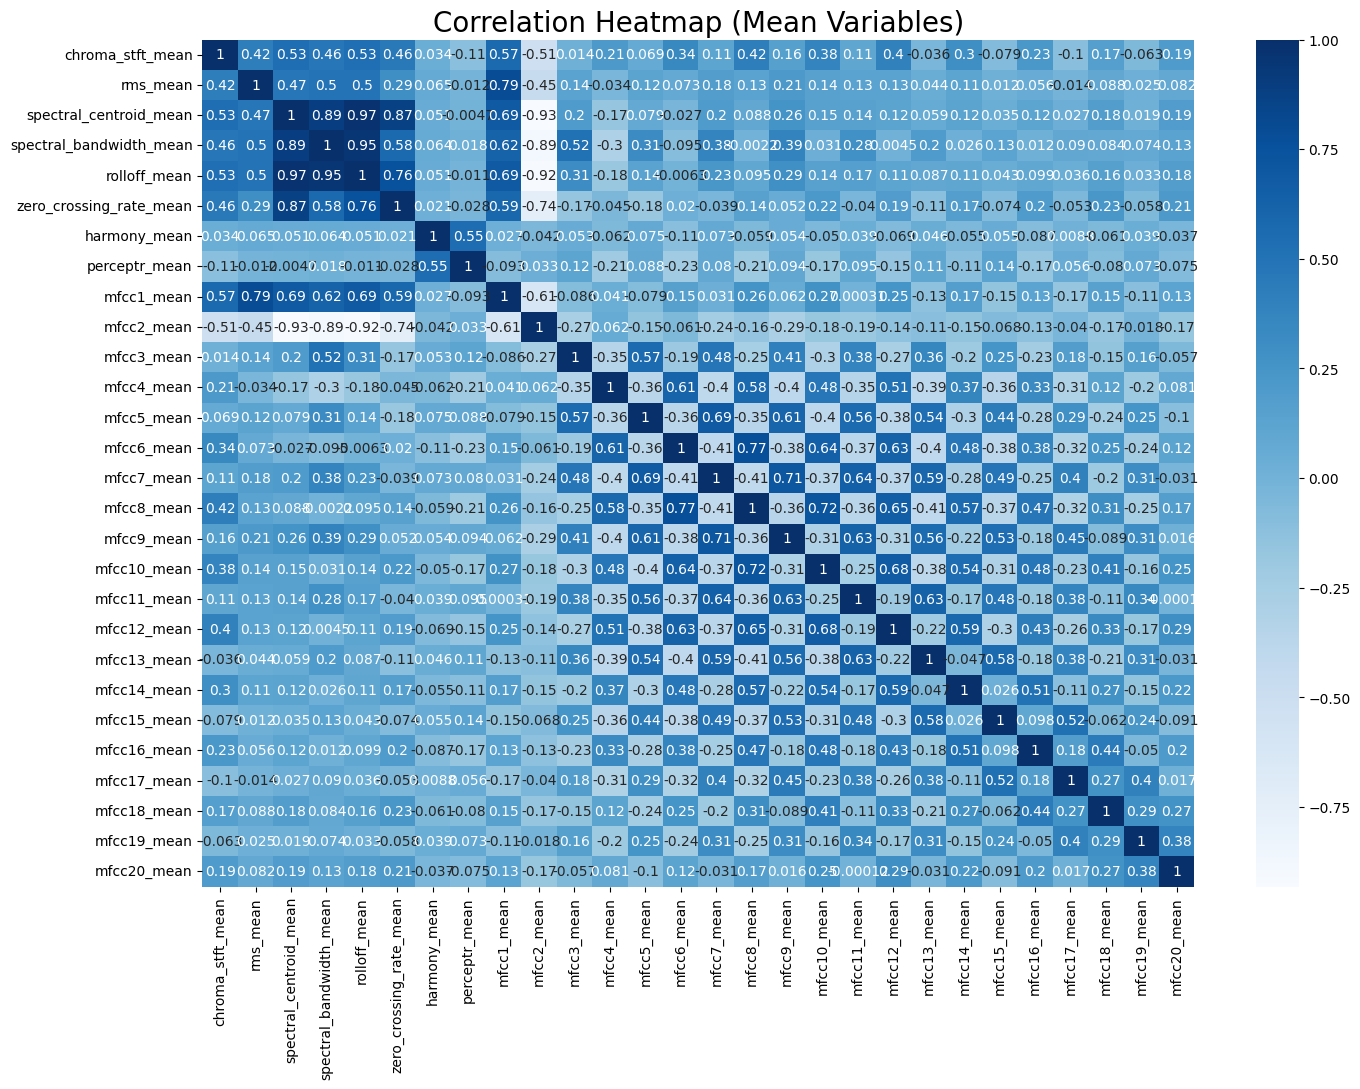

In [ ]:
mean_cols = [col for col in data.columns if 'mean' in col]
plt.figure(figsize=(16, 11))
sns.heatmap(data[mean_cols].corr(), cmap='Blues', annot=True)
plt.title('Correlation Heatmap (Mean Variables)', fontsize=20)
plt.show()

## **Correlation Heatmap for Variance Variables**

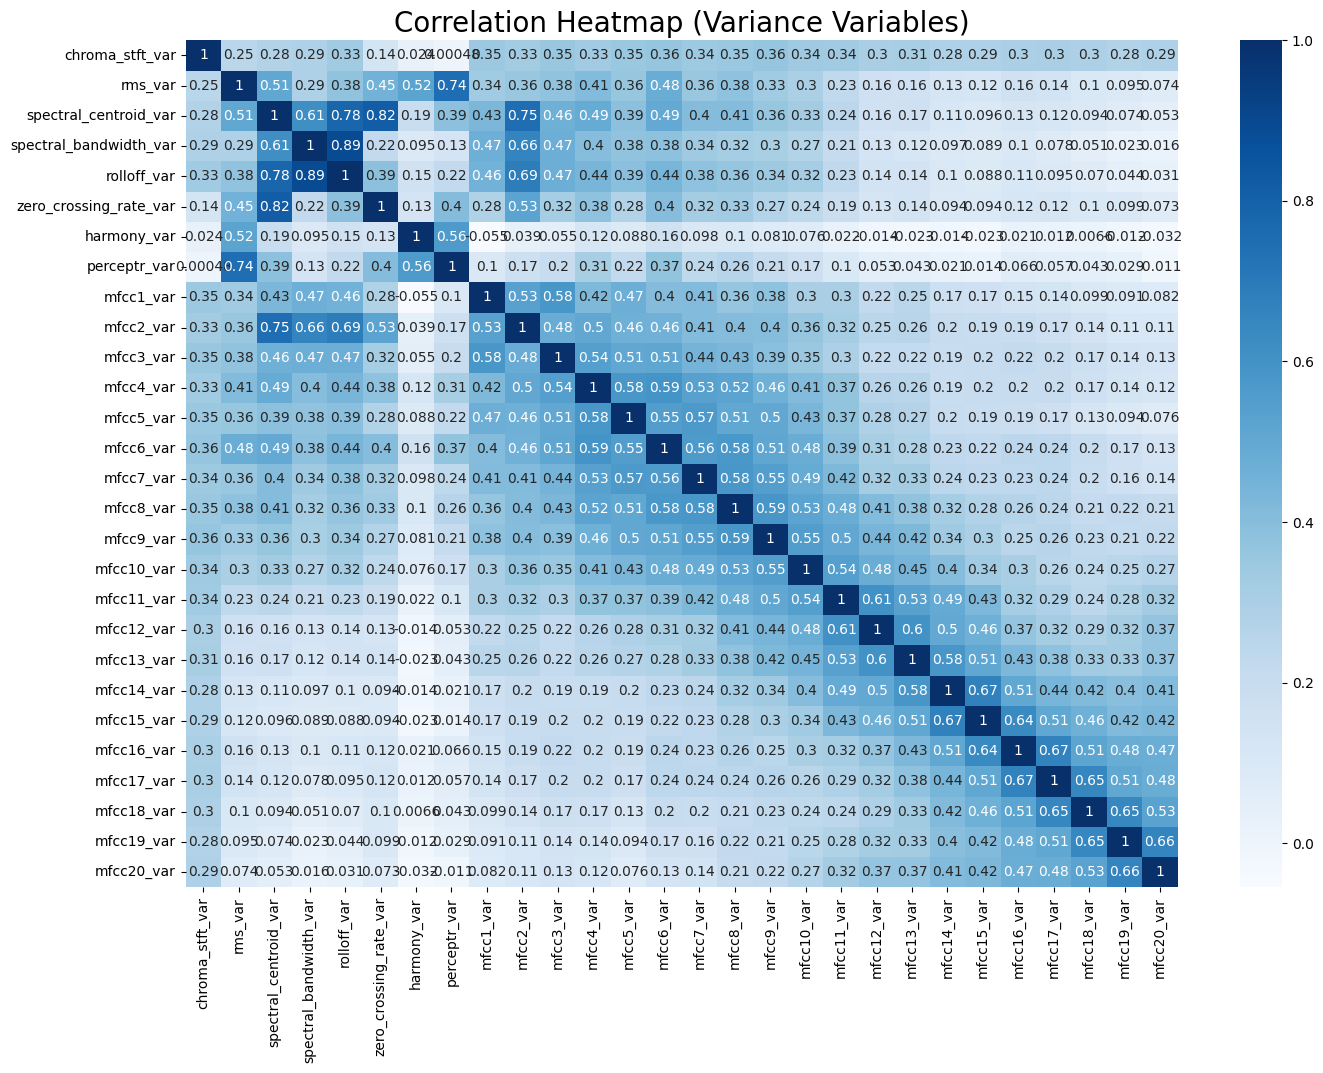

In [ ]:
var_cols = [col for col in data.columns if 'var' in col]
plt.figure(figsize=(16, 11))
sns.heatmap(data[var_cols].corr(), cmap='Blues', annot=True)
plt.title('Correlation Heatmap (Variance Variables)', fontsize=20)
plt.show()

## **Preprocessing**

In [ ]:
data.drop(['filename', 'length'], axis=1, inplace=True)
data['label'] = LabelEncoder().fit_transform(data['label'])
X = data.drop(['label'], axis=1)
y = data['label']

## **Scaling features**

In [ ]:
scaler = MinMaxScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

## **Principal Component Analysis (PCA)**

In [ ]:
pca = PCA(n_components=24)
X_pca = pd.DataFrame(pca.fit_transform(X_scaled))

## **Split dataset into training, validation, and test sets**

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=42)

print(f'Training set shape: {X_train.shape}')
print(f'Validation set shape: {X_val.shape}')
print(f'Test set shape: {X_test.shape}')

Training set shape: (5994, 57)
Validation set shape: (1998, 57)
Test set shape: (1998, 57)


## **Scaling and Encoding**

In [ ]:

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
labelencoder = LabelEncoder()
y_train = labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

## **Normalization**

In [ ]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# **Define Plot**

In [ ]:
def plot_history(hist):
    plt.figure(figsize=(20, 15))
    fig, axs = plt.subplots(2)
    axs[0].plot(hist.history["accuracy"], label="Train Accuracy")
    axs[0].plot(hist.history["val_accuracy"], label="Test Accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy Evaluation")

    axs[1].plot(hist.history["loss"], label="Train Loss")
    axs[1].plot(hist.history["val_loss"], label="Test Loss")
    axs[1].set_ylabel("Loss")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Loss Evaluation")

    plt.show()

### **FCN_LSTM**

In [ ]:
# Build FCN-LSTM model
fcn_lstm_model = Sequential()
# 1D Convolutional layers
# Reshape the input for Conv1D
fcn_lstm_model.add(Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=(1,57)))
fcn_lstm_model.add(BatchNormalization())
fcn_lstm_model.add(Dropout(0.3))
fcn_lstm_model.add(Conv1D(256, kernel_size=3, activation='relu', padding='same'))
fcn_lstm_model.add(BatchNormalization())
fcn_lstm_model.add(Dropout(0.3))
# LSTM Layer
# Remove the Flatten layer
fcn_lstm_model.add(LSTM(256, return_sequences=False))
fcn_lstm_model.add(Dropout(0.5))
# Dense Layers
fcn_lstm_model.add(Dense(256, activation='relu'))
fcn_lstm_model.add(Dropout(0.5))
# Assuming y is your target variable
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y)
fcn_lstm_model.add(Dense(len(np.unique(y_encoded)), activation='softmax'))
# Ensure your input data is in the correct format (batch_size, 1, features)
X_train_fcn_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_fcn_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

fcn_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 1, 128)              │          22,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 1, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 1, 256)              │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 1, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           2,570 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 715,786 (2.73 MB)

 Trainable params: 715,018 (2.73 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
# Compile and train FCN-LSTM model
fcn_lstm_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
fcn_lstm_history = fcn_lstm_model.fit(X_train_fcn_lstm, y_train, epochs=500, batch_size=200, validation_data=(X_test_fcn_lstm, y_test),verbose=1)

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step - accuracy: 0.1185 - loss: 2.3045 - val_accuracy: 0.2397 - val_loss: 2.3000
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.2200 - loss: 2.1920 - val_accuracy: 0.2898 - val_loss: 2.2948
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2895 - loss: 2.0710 - val_accuracy: 0.2302 - val_loss: 2.2843
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.3317 - loss: 1.9345 - val_accuracy: 0.1772 - val_loss: 2.2668
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3642 - loss: 1.8174 - val_accuracy: 0.1817 - val_loss: 2.2439
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - accuracy: 0.3938 - loss: 1.7358 - val_accuracy: 0.1972 - val_loss: 2.2170
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4397 - loss: 1.6157 - val_accuracy: 0.2237 - val_loss: 2.1836
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - accuracy: 0.4499 - loss: 1.5732 - val_accuracy: 0.

<Figure size 2000x1500 with 0 Axes>

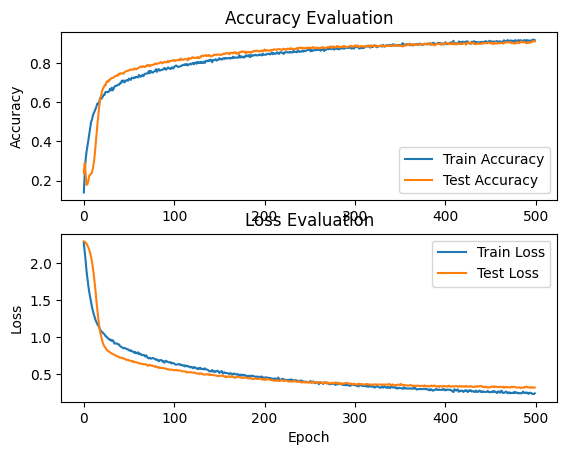

Training Loss: 0.23760226368904114
Training Accuracy: 0.9190857410430908
Test Loss: 0.31653016805648804
Test Accuracy: 0.9124124050140381


In [ ]:
# Plot training history
plot_history(fcn_lstm_history)
# Retrieve the last epoch's training and validation accuracy and loss
train_accuracy_fcn_lstm = fcn_lstm_history.history['accuracy'][-1]
test_accuracy_fcn_lstm = fcn_lstm_history.history['val_accuracy'][-1]
train_loss_fcn_lstm = fcn_lstm_history.history['loss'][-1]
test_loss_fcn_lstm = fcn_lstm_history.history['val_loss'][-1]

# Print the retrieved metrics
print('Training Loss:', train_loss_fcn_lstm)
print('Training Accuracy:', train_accuracy_fcn_lstm)
print('Test Loss:', test_loss_fcn_lstm)
print('Test Accuracy:', test_accuracy_fcn_lstm)



63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix:
 [[185   0   9   0   2   0   3   0   0   1]
 [  0 195   0   0   1   2   0   0   0   2]
 [  7   2 175   2   0   4   1   2   4   2]
 [  0   0   2 185   4   0   2   2   0   5]
 [  0   0   0   7 182   0   1   3   7   0]
 [  6   7   1   0   0 186   0   0   0   0]
 [  4   0   1   0   1   0 190   0   1   3]
 [  0   0   5   7   5   1   0 179   0   3]
 [  2   0   4   0   4   1   0   2 186   1]
 [  4   1  13   9   0   2   7   1   2 160]]


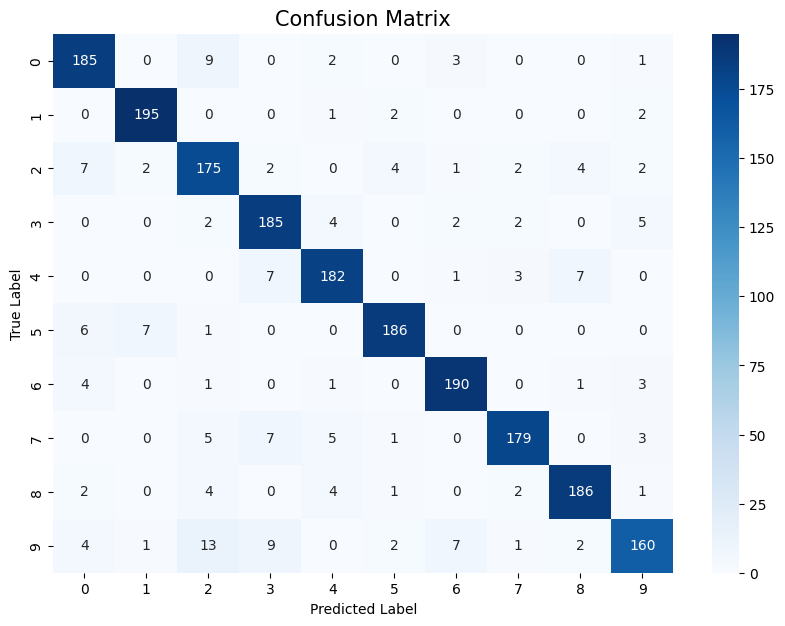

In [ ]:
# Predict classes on the test set
y_pred_fcn_lstm = fcn_lstm_model.predict(X_test_fcn_lstm)
y_pred_classes_fcn_lstm = np.argmax(y_pred_fcn_lstm, axis=1)
# Confusion Matrix
conf_matrix_fcn_lstm = confusion_matrix(y_test, y_pred_classes_fcn_lstm)
print("Confusion Matrix:\n", conf_matrix_fcn_lstm)
# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_fcn_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.93      0.91       200
           1       0.95      0.97      0.96       200
           2       0.83      0.88      0.86       199
           3       0.88      0.93      0.90       200
           4       0.91      0.91      0.91       200
           5       0.95      0.93      0.94       200
           6       0.93      0.95      0.94       200
           7       0.95      0.90      0.92       200
           8       0.93      0.93      0.93       200
           9       0.90      0.80      0.85       199

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



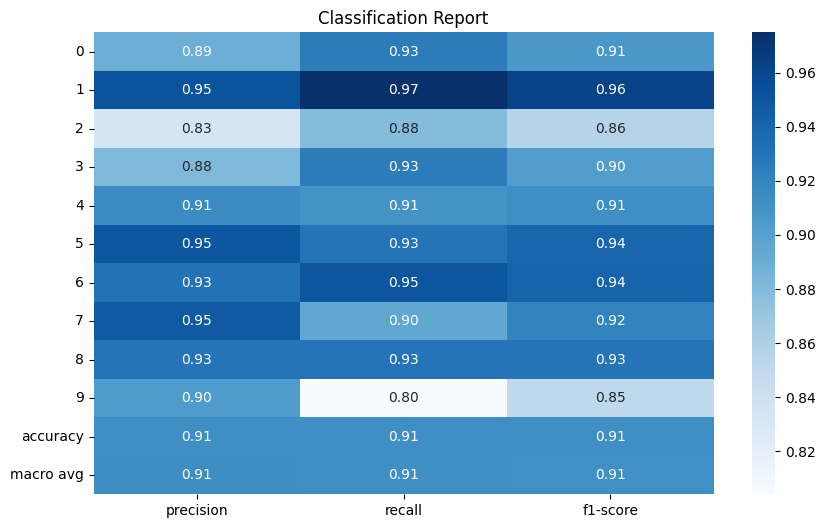

In [ ]:
# Classification Report
print("\nClassification Report:")
report_fcn_lstm = classification_report(y_test, y_pred_classes_fcn_lstm, output_dict=True)
print(classification_report(y_test, y_pred_classes_fcn_lstm))
# Plot the classification report
def plot_classification_report(report_fcn_lstm):
    report_df = pd.DataFrame(report_fcn_lstm).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()
plot_classification_report(report_fcn_lstm)

In [ ]:
fcn_lstm_accuracy = accuracy_score(y_test, y_pred_classes_fcn_lstm)
print(f"FCN_LSTM Overall Accuracy: {fcn_lstm_accuracy:.2f}")


FCN_LSTM Overall Accuracy: 0.91


188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - accuracy: 0.8647 - loss: 0.3793
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


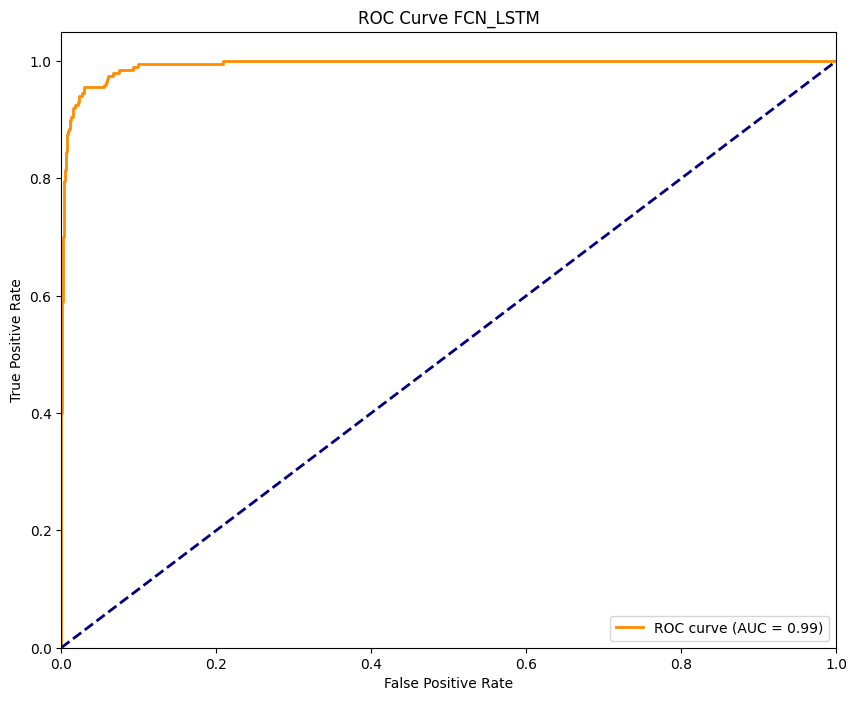

In [ ]:
fcn_lstm_model.fit(X_train_fcn_lstm, y_train)
probs = fcn_lstm_model.predict(X_test_fcn_lstm)
# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot ROC curve for a specific class (e.g., class 0)
plt.figure(figsize=(10, 8))
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc[0]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve FCN_LSTM')
plt.legend(loc='lower right')
plt.show()

## **RESNET**

In [ ]:
# ResNet Model
resnet_model = Sequential()
resnet_model.add(Dense(2048, input_dim=X_train.shape[1], activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(BatchNormalization())
resnet_model.add(Dense(len(np.unique(y_train)), activation='softmax'))
resnet_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 2048)                │         118,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 1024)                │           4,096 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,239,498 (8.54 MB)

 Trainable params: 2,233,354 (8.52 MB)

 Non-trainable params: 6,144 (24.00 KB)

In [ ]:
# Compile and train ResNet model
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
resnet_history = resnet_model.fit(X_train, y_train, batch_size=200, epochs=100, validation_data=(X_test,y_test), verbose=1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.5358 - loss: 1.7350 - val_accuracy: 0.1026 - val_loss: 2.2131
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - accuracy: 0.7840 - loss: 0.6517 - val_accuracy: 0.1081 - val_loss: 2.2814
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8464 - loss: 0.4660 - val_accuracy: 0.1537 - val_loss: 2.4723
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - accuracy: 0.8891 - loss: 0.3509 - val_accuracy: 0.1486 - val_loss: 2.6216
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 141ms/step - accuracy: 0.9020 - loss: 0.2949 - val_accuracy: 0.1471 - val_loss: 2.7659
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.9214 - loss: 0.2428 - val_accuracy: 0.1562 - val_loss: 2.7492
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - accuracy: 0.9546 - loss: 0.1841 - val_accuracy: 0.1522 - val_loss: 2.8535
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9625 - loss: 0.1463 - val_accuracy: 

<Figure size 2000x1500 with 0 Axes>

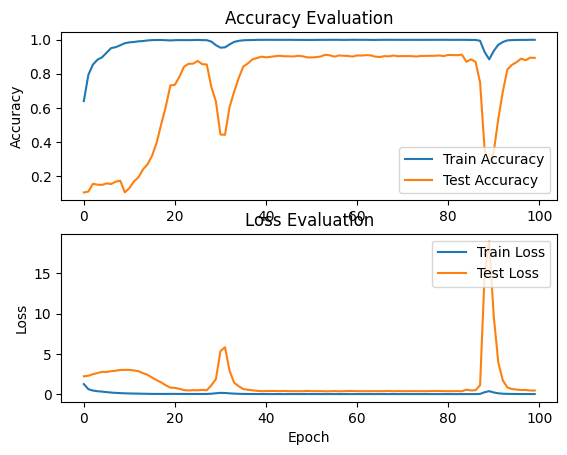

Training Loss: 0.005691580940037966
Training Accuracy: 0.9993326663970947
Test Loss: 0.44597360491752625
Test Accuracy: 0.8933933973312378


In [ ]:
plot_history(resnet_history)
# Retrieve the last epoch's training and validation accuracy and loss
train_accuracy_resnet = resnet_history.history['accuracy'][-1]
test_accuracy_resnet = resnet_history.history['val_accuracy'][-1]
train_loss_resnet = resnet_history.history['loss'][-1]
test_loss_resnet = resnet_history.history['val_loss'][-1]
# Print the retrieved metrics
print('Training Loss:', train_loss_resnet)
print('Training Accuracy:', train_accuracy_resnet)
print('Test Loss:', test_loss_resnet)
print('Test Accuracy:', test_accuracy_resnet)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix:
 [[179   0  10   2   0   2   2   0   2   3]
 [  0 192   1   0   1   4   0   0   0   2]
 [  9   1 177   1   0   5   0   3   1   2]
 [  1   0   4 177   1   1   2   7   1   6]
 [  2   0   2   6 177   0   1   6   6   0]
 [  3   9   2   0   0 183   0   2   1   0]
 [  3   0   3   1   2   1 183   0   1   6]
 [  1   0   7   5   6   1   0 174   2   4]
 [  6   0   7   0   2   2   0   2 180   1]
 [  2   2  18   3   0   1   5   3   2 163]]


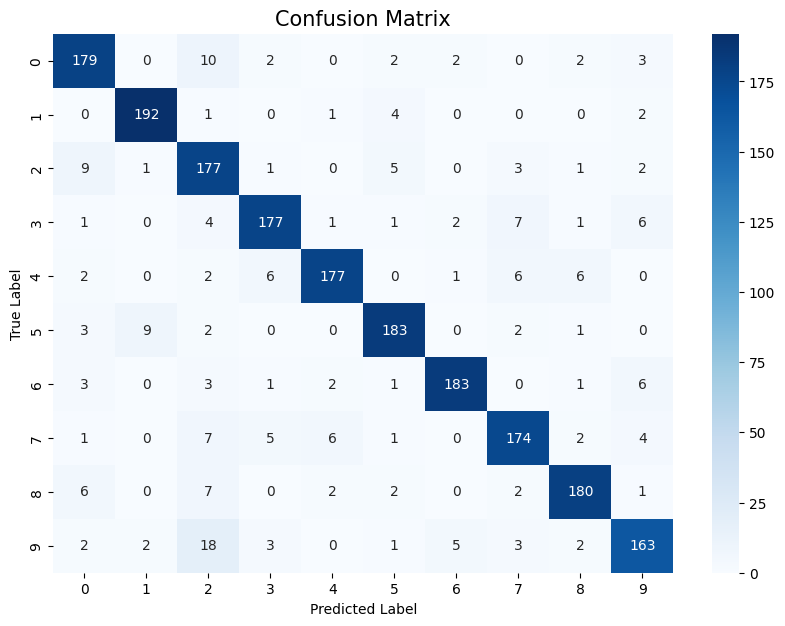

In [ ]:
y_pred_resnet = resnet_model.predict(X_test)
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)

# Confusion Matrix
conf_matrix_resnet = confusion_matrix(y_test, y_pred_classes_resnet)
print("Confusion Matrix:\n", conf_matrix_resnet)
# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_resnet, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()






Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       200
           1       0.94      0.96      0.95       200
           2       0.77      0.89      0.82       199
           3       0.91      0.89      0.90       200
           4       0.94      0.89      0.91       200
           5       0.92      0.92      0.92       200
           6       0.95      0.92      0.93       200
           7       0.88      0.87      0.88       200
           8       0.92      0.90      0.91       200
           9       0.87      0.82      0.84       199

    accuracy                           0.89      1998
   macro avg       0.90      0.89      0.89      1998
weighted avg       0.90      0.89      0.89      1998



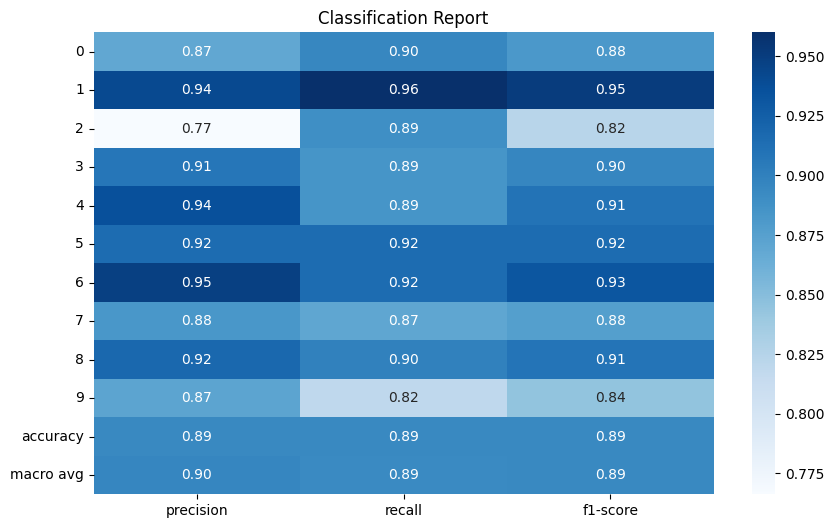

In [ ]:
# Classification Report
print("\nClassification Report:")
report_resnet = classification_report(y_test, y_pred_classes_resnet, output_dict=True)
print(classification_report(y_test, y_pred_classes_resnet))
# Plot the classification report
def plot_classification_report(report_resnet):
    report_df = pd.DataFrame(report_resnet).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()
plot_classification_report(report_resnet)

In [ ]:
resnet_accuracy = accuracy_score(y_test, y_pred_classes_resnet)
print(f"RESNET Overall Accuracy: {resnet_accuracy:.2f}")

RESNET Overall Accuracy: 0.89


188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - accuracy: 0.8538 - loss: 0.4403
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


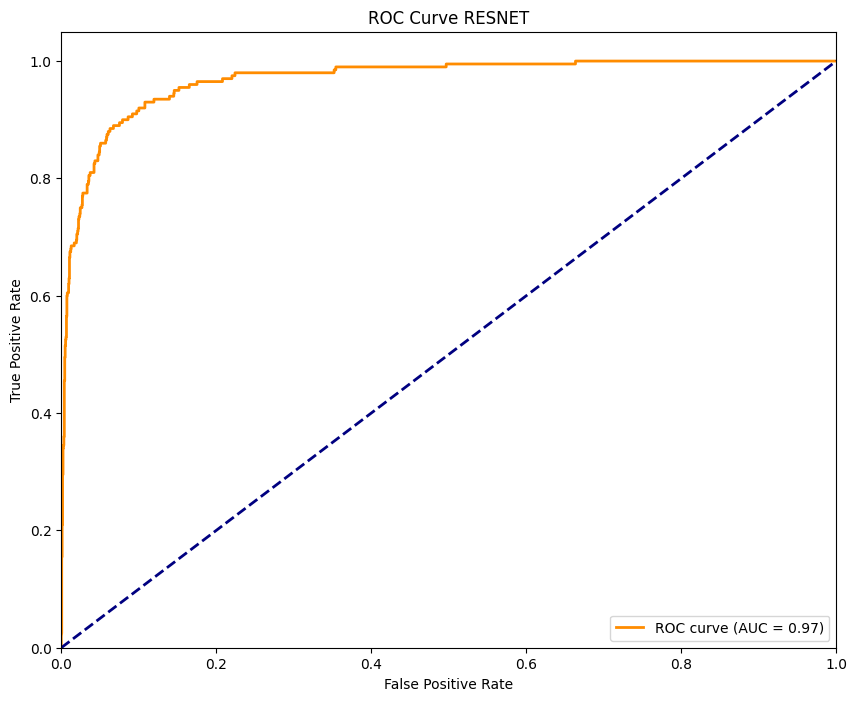

In [ ]:
resnet_model.fit(X_train, y_train)
probs = resnet_model.predict(X_test)
# Binarize the output
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
# Plot ROC curve for a specific class (e.g., class 0)
plt.figure(figsize=(10, 8))
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc[0]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve RESNET')
plt.legend(loc='lower right')
plt.show()

## **SVM**

In [ ]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}
# Perform grid search to find the best parameters
svm_grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
svm_grid.fit(X_train, y_train)
svm_best = SVC(**svm_grid.best_params_, random_state=42, probability=True)
svm_best.fit(X_train, y_train)
# Predictions
y_pred_svm_test = svm_best.predict(X_test)
y_pred_svm_train = svm_best.predict(X_train)
# Accuracy
from sklearn.metrics import accuracy_score
train_accuracy_svm = accuracy_score(y_train, y_pred_svm_train)
test_accuracy_svm = accuracy_score(y_test, y_pred_svm_test)
# Loss
train_loss_svm = log_loss(y_train, svm_best.predict_proba(X_train))
test_loss_svm = log_loss(y_test, svm_best.predict_proba(X_test))
# Confusion Matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred_svm_test)
# Classification Report
from sklearn.metrics import classification_report
class_report = classification_report(y_test, y_pred_svm_test, output_dict=True)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   1.7s
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=   2.5s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.3s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.4s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   1.0s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.8s
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time=   0.8s
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time=   4.2s
[CV] END .....................C=0.1, gamma=1, k

Training accuracy: 0.9993326659993327
Test accuracy: 0.9074074074074074
Training loss: 0.043800866762509195
Test loss: 0.30500964043108597


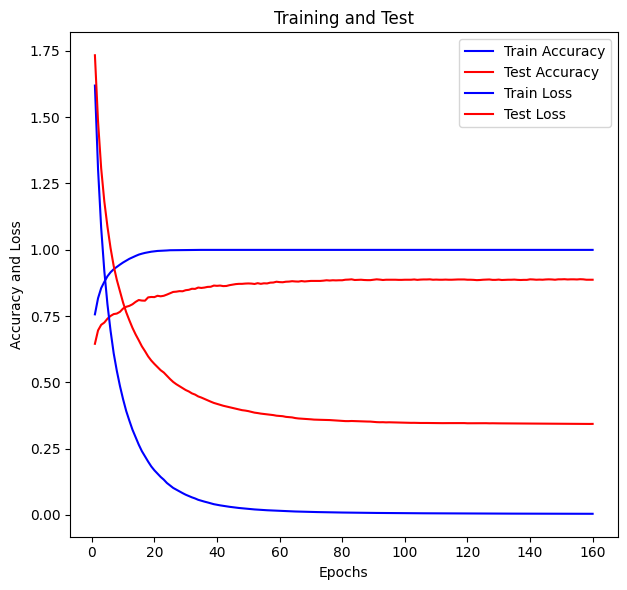

In [ ]:
X_train_svm = np.reshape(X_train, (X_train.shape[0], -1))
y_pred_svm_test = svm_best.predict(X_test)
y_pred_svm_train = svm_best.predict(X_train_svm)
train_accuracy_svm = accuracy_score(y_train, y_pred_svm_train)
test_accuracy_svm = accuracy_score(y_test, y_pred_svm_test)
train_loss_svm = log_loss(y_train, svm_best.predict_proba(X_train))
print("Training accuracy:", train_accuracy_svm)
print("Test accuracy:", test_accuracy_svm)
print("Training loss:", train_loss_svm)
print("Test loss:", test_loss_svm)
epochs = range(1, len(train_error) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, np.array(1) - np.array(train_error), 'b-', label='Train Accuracy')
plt.plot(epochs, np.array(1) - np.array(test_error), 'r-', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.plot(epochs, train_logloss, 'b-', label='Train Loss')
plt.plot(epochs, test_logloss, 'r-', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy and Loss')
plt.title('Training and Test')
plt.legend()
plt.tight_layout()
plt.show()

Confusion Matrix:
 [[188   0   5   0   0   1   1   0   1   4]
 [  0 194   2   0   0   3   0   0   0   1]
 [ 11   0 176   1   0   4   0   2   1   4]
 [  1   0   1 186   2   0   3   2   0   5]
 [  1   0   2   4 182   0   2   1   6   2]
 [  6   5   2   1   0 185   0   1   0   0]
 [  1   0   1   2   5   1 184   0   2   4]
 [  0   0   4   8   3   2   0 179   4   0]
 [  3   0   5   1   3   3   0   1 180   4]
 [  3   1  14   9   0   2   4   3   4 159]]


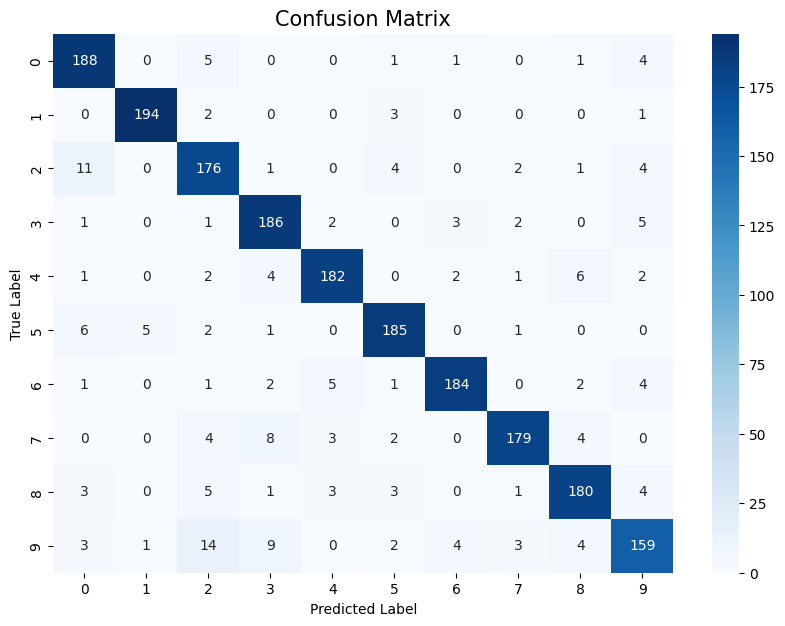

In [ ]:
test_loss_svm = log_loss(y_test, svm_best.predict_proba(X_test))
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm_test)
print("Confusion Matrix:\n", conf_matrix_svm)
# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_svm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.94      0.91       200
           1       0.97      0.97      0.97       200
           2       0.83      0.88      0.86       199
           3       0.88      0.93      0.90       200
           4       0.93      0.91      0.92       200
           5       0.92      0.93      0.92       200
           6       0.95      0.92      0.93       200
           7       0.95      0.90      0.92       200
           8       0.91      0.90      0.90       200
           9       0.87      0.80      0.83       199

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



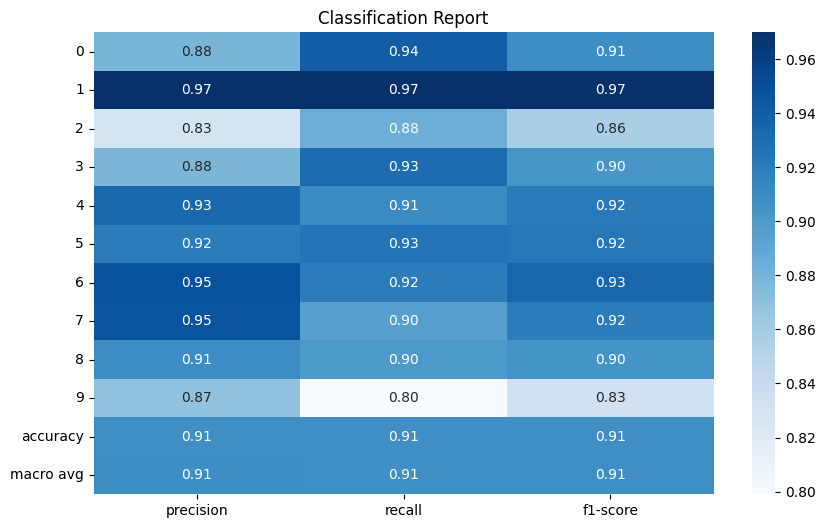

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred_svm_test))
report_svm = classification_report(y_test, y_pred_svm_test, output_dict=True)
# Plot the classification report
def plot_classification_report(report_svm):
    report_df = pd.DataFrame(report_svm).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()
plot_classification_report(report_svm)

In [ ]:
svm_accuracy = accuracy_score(y_test, y_pred_svm_test)
print(f"SVM Overall Accuracy: {svm_accuracy:.2f}")

SVM Overall Accuracy: 0.91


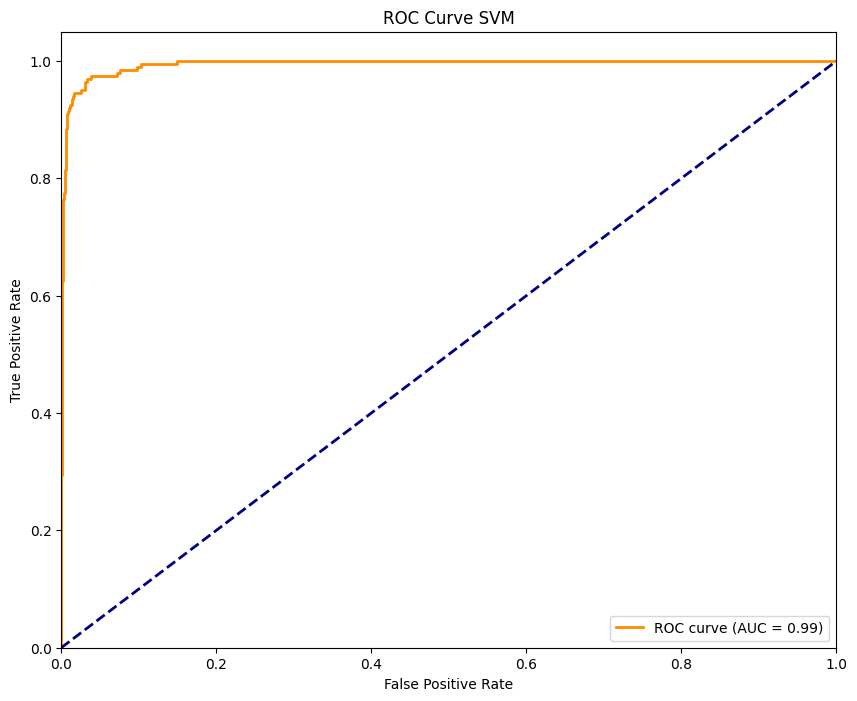

In [ ]:
X_test_svm = np.reshape(X_test, (X_test.shape[0], -1))
svm_best.fit(X_train_svm, y_train)
probs = svm_best.predict_proba(X_test_svm)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure(figsize=(10, 8))
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc[0]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve SVM')
plt.legend(loc='lower right')
plt.show()

## **FCN**

In [ ]:
# Define the FCN model
fcn_model = Sequential()
fcn_model.add(Dense(4000, input_dim=X_train.shape[1], activation='relu'))
fcn_model.add(Dense(1024, activation='relu'))
fcn_model.add(Dense(len(labelencoder.classes_), activation='softmax'))
fcn_model.summary()
# Compile the model
fcn_model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 4000)                │         232,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1024)                │       4,097,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 10)                  │          10,250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,339,274 (16.55 MB)

 Trainable params: 4,339,274 (16.55 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train_fcn = np.reshape(X_train, (X_train.shape[0], X_train.shape[1]))
X_test_fcn = np.reshape(X_test, (X_test.shape[0], X_test.shape[1]))
fcn_history = fcn_model.fit(X_train_fcn, y_train, batch_size=200, epochs=100, validation_data=(X_test_fcn,y_test), verbose=1)

Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 187ms/step - accuracy: 0.3129 - loss: 1.9226 - val_accuracy: 0.5180 - val_loss: 1.3612
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 206ms/step - accuracy: 0.5512 - loss: 1.2607 - val_accuracy: 0.5956 - val_loss: 1.1101
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 168ms/step - accuracy: 0.6101 - loss: 1.0895 - val_accuracy: 0.6246 - val_loss: 1.0270
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 215ms/step - accuracy: 0.6311 - loss: 1.0247 - val_accuracy: 0.6441 - val_loss: 0.9921
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 153ms/step - accuracy: 0.6572 - loss: 0.9652 - val_accuracy: 0.6647 - val_loss: 0.9431
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.6764 - loss: 0.9164 - val_accuracy: 0.6947 - val_loss: 0.8689
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step - accuracy: 0.7056 - loss: 0.8458 - val_accuracy: 0.6552 - val_loss: 0.9705
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 255ms/step - accuracy: 0.6995 - loss: 0.8558 - val_acc

<Figure size 2000x1500 with 0 Axes>

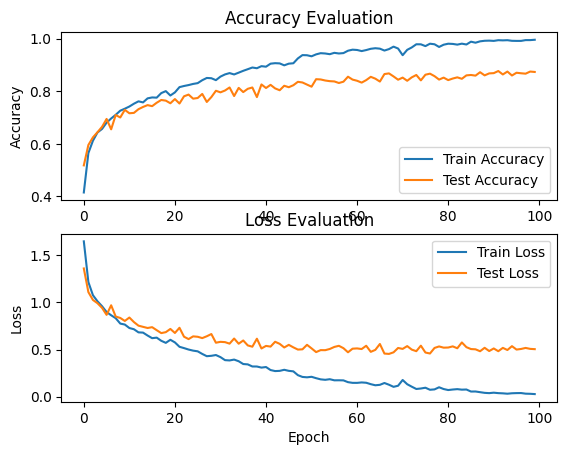

Training Loss: 0.027952982112765312
Training Accuracy: 0.995829164981842
Test Loss: 0.5047229528427124
Test Accuracy: 0.8733733892440796


In [ ]:
plot_history(fcn_history)
train_accuracy_fcn = fcn_history.history['accuracy'][-1]
test_accuracy_fcn = fcn_history.history['val_accuracy'][-1]
train_loss_fcn = fcn_history.history['loss'][-1]
test_loss_fcn = fcn_history.history['val_loss'][-1]
print('Training Loss:', train_loss_fcn)
print('Training Accuracy:', train_accuracy_fcn)
print('Test Loss:', test_loss_fcn)
print('Test Accuracy:', test_accuracy_fcn)


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
Confusion Matrix:
 [[178   0   7   2   5   1   4   1   0   2]
 [  0 190   0   1   1   6   0   0   0   2]
 [ 12   0 158   4   4   3   2   5   4   7]
 [  0   0   2 179   5   0   2   3   5   4]
 [  0   0   0   3 189   0   2   2   3   1]
 [  8   3   3   2   1 181   0   1   0   1]
 [  2   0   0   2   6   0 185   0   1   4]
 [  0   0   5   5   7   1   0 174   6   2]
 [  3   0   6   0   8   4   0   2 175   2]
 [  8   0  17  14   2   5  10   5   2 136]]


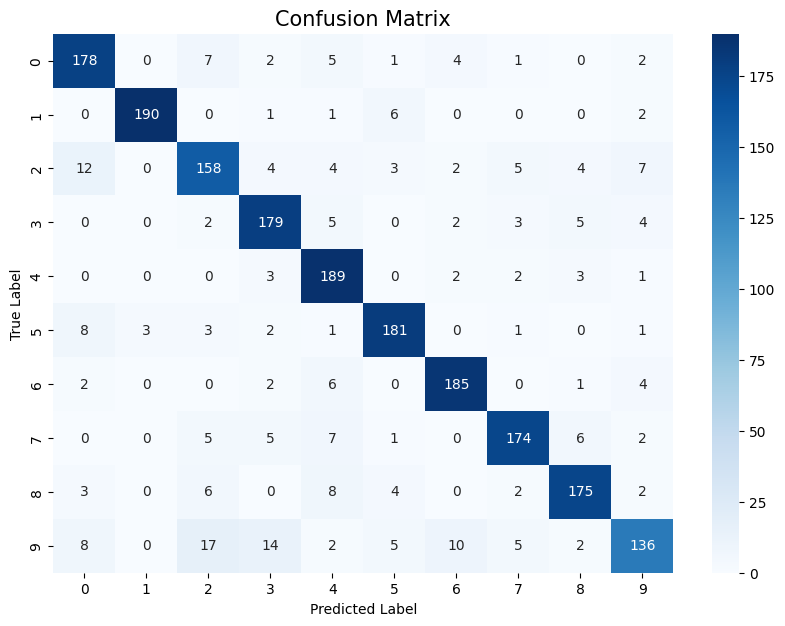

In [ ]:
# Predict classes on the test set
y_pred_fcn = fcn_model.predict(X_test_fcn)
y_pred_classes_fcn = np.argmax(y_pred_fcn, axis=1)
# Confusion Matrix
conf_matrix_fcn = confusion_matrix(y_test, y_pred_classes_fcn)
print("Confusion Matrix:\n", conf_matrix_fcn)
# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_fcn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87       200
           1       0.98      0.95      0.97       200
           2       0.80      0.79      0.80       199
           3       0.84      0.90      0.87       200
           4       0.83      0.94      0.88       200
           5       0.90      0.91      0.90       200
           6       0.90      0.93      0.91       200
           7       0.90      0.87      0.89       200
           8       0.89      0.88      0.88       200
           9       0.84      0.68      0.76       199

    accuracy                           0.87      1998
   macro avg       0.87      0.87      0.87      1998
weighted avg       0.87      0.87      0.87      1998



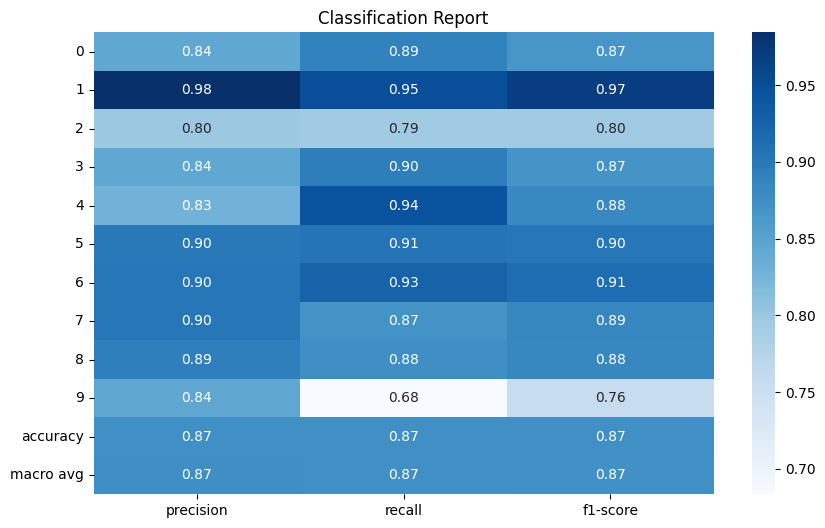

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred_classes_fcn))
report_fcn = classification_report(y_test, y_pred_classes_fcn, output_dict=True)
# Plot the classification report
def plot_classification_report(report_fcn):
    report_df = pd.DataFrame(report_fcn).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()

plot_classification_report(report_fcn)

In [ ]:
fcn_accuracy = accuracy_score(y_test, y_pred_classes_fcn)
print(f"FCN Overall Accuracy: {fcn_accuracy:.2f}")

FCN Overall Accuracy: 0.87


188/188 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.8078 - loss: 0.5257
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


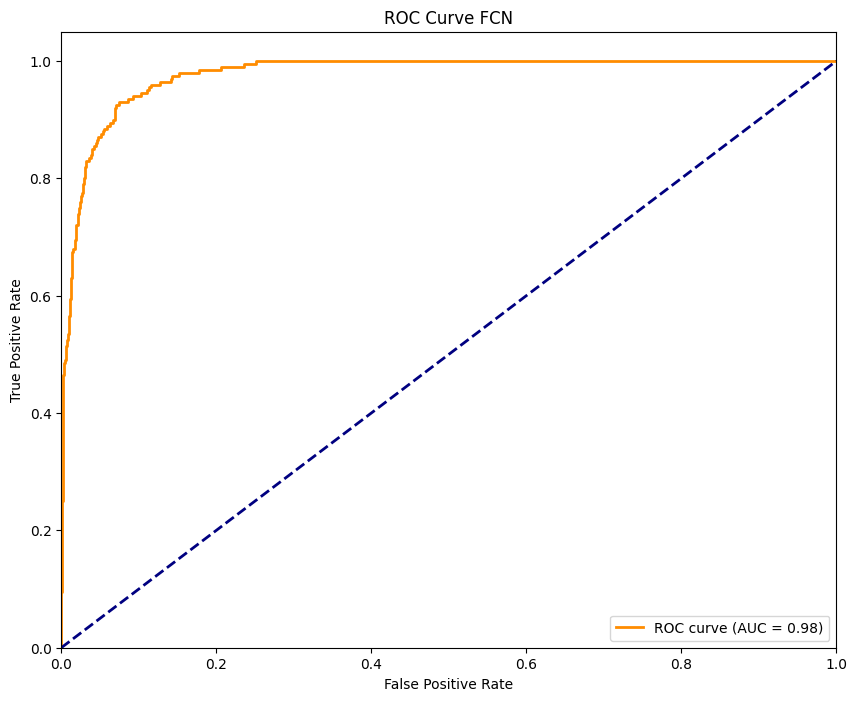

In [ ]:
fcn_model.fit(X_train_fcn, y_train)
probs = fcn_model.predict(X_test_fcn)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure(figsize=(10, 8))
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc[0]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve FCN')
plt.legend(loc='lower right')
plt.show()

## **LSTM**

In [ ]:
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
lstm_model = Sequential([
    Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),
    Conv1D(filters=256, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(128, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.3),
    LSTM(32),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])
# Compile the model
lstm_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 55, 64)              │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 27, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 27, 64)              │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 27, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 25, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 12, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 12, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 10, 256)             │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 5, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 5, 256)              │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 5, 256)              │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 5, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 5, 128)              │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 5, 128)              │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 5, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 32)                  │          20,6

 Total params: 706,506 (2.70 MB)

 Trainable params: 704,778 (2.69 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [ ]:
# --- Train the Model ---
lstm_history = lstm_model.fit(X_train_lstm, y_train, epochs=200, batch_size=200,
                          validation_data=(X_test_lstm, y_test),verbose=1)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.2056 - loss: 2.5427 - val_accuracy: 0.1016 - val_loss: 2.3071
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 179ms/step - accuracy: 0.3540 - loss: 1.8704 - val_accuracy: 0.0996 - val_loss: 2.3449
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 215ms/step - accuracy: 0.4258 - loss: 1.6569 - val_accuracy: 0.0996 - val_loss: 2.3757
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.4593 - loss: 1.5484 - val_accuracy: 0.1231 - val_loss: 2.3628
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 179ms/step - accuracy: 0.4947 - loss: 1.4470 - val_accuracy: 0.1401 - val_loss: 2.3384
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 12s 243ms/step - accuracy: 0.5093 - loss: 1.3862 - val_accuracy: 0.1522 - val_loss: 2.3510
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 205ms/step - accuracy: 0.5264 - loss: 1.3432 - val_accuracy: 0.1171 - val_loss: 2.4496
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 10s 186ms/step - accuracy: 0.5540 - loss: 1.2649 - val

<Figure size 2000x1500 with 0 Axes>

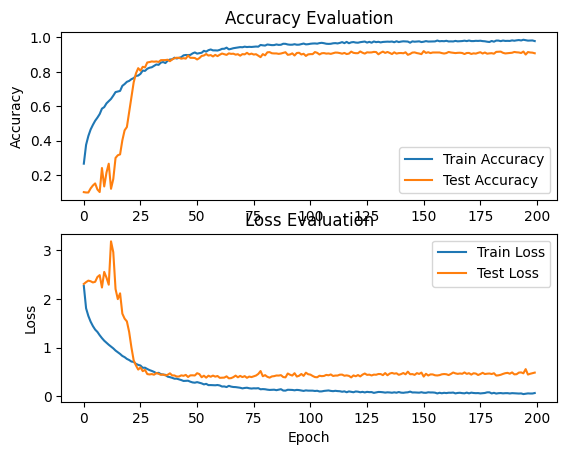

Training Loss: 0.06880368292331696
Training Accuracy: 0.9786453247070312
Test Loss: 0.4877840280532837
Test Accuracy: 0.9079079031944275


In [ ]:
plot_history(lstm_history)
train_loss = lstm_history.history['loss'][-1]
train_accuracy = lstm_history.history['accuracy'][-1]
val_loss = lstm_history.history['val_loss'][-1]
val_accuracy = lstm_history.history['val_accuracy'][-1]
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Loss: {val_loss}")
print(f"Test Accuracy: {val_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step
Confusion Matrix:
 [[174   1   8   1   1   4   3   0   2   6]
 [  0 193   1   0   0   3   0   0   2   1]
 [  3   0 175   1   1   8   1   1   3   6]
 [  0   0   0 185   1   0   4   3   1   6]
 [  1   0   2   4 176   0   4  10   2   1]
 [  3   8   2   0   0 184   0   0   1   2]
 [  5   0   1   1   2   0 187   0   1   3]
 [  0   0   3   4   1   0   0 183   4   5]
 [  2   0   6   1   1   0   0   2 185   3]
 [  2   1   8   3   2   3   5   2   1 172]]


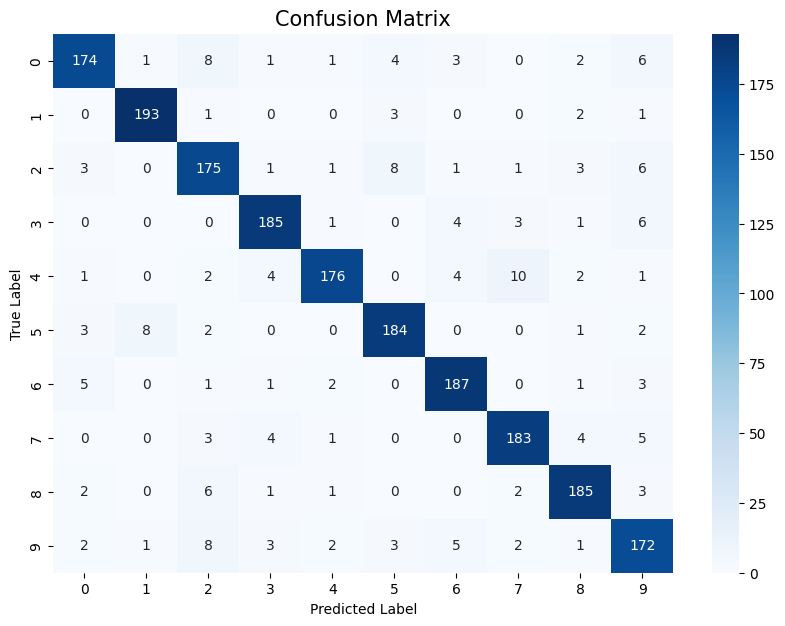

In [ ]:
X_test_lstm = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Make predictions
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)
# Confusion Matrix
conf_matrix_lstm = confusion_matrix(y_test, y_pred_classes_lstm)
print("Confusion Matrix:\n", conf_matrix_lstm)
# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.87      0.89       200
           1       0.95      0.96      0.96       200
           2       0.85      0.88      0.86       199
           3       0.93      0.93      0.93       200
           4       0.95      0.88      0.91       200
           5       0.91      0.92      0.92       200
           6       0.92      0.94      0.93       200
           7       0.91      0.92      0.91       200
           8       0.92      0.93      0.92       200
           9       0.84      0.86      0.85       199

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



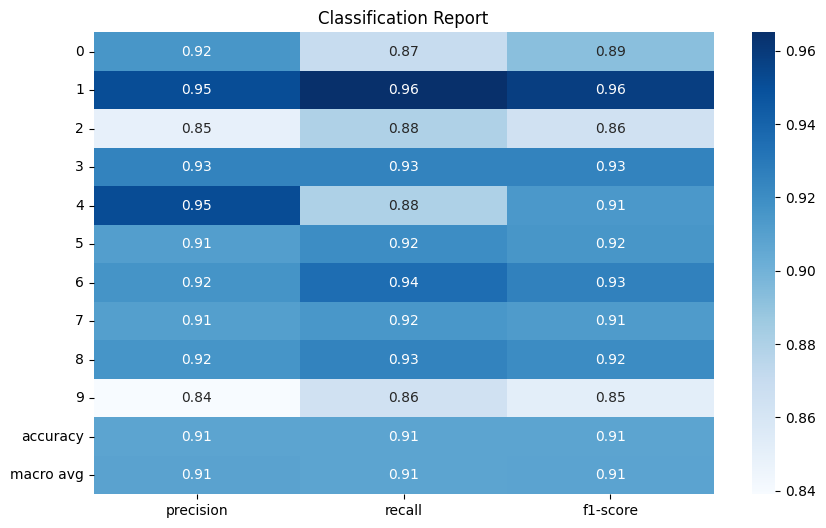

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred_classes_lstm))
report_lstm = classification_report(y_test, y_pred_classes_lstm, output_dict=True)
# Plot the classification report
def plot_classification_report(report_lstm):
    report_df = pd.DataFrame(report_lstm).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()

plot_classification_report(report_lstm)

In [ ]:
lstm_accuracy = accuracy_score(y_test, y_pred_classes_lstm)
print(f"LSTM Overall Accuracy: {lstm_accuracy:.2f}")

LSTM Overall Accuracy: 0.91


188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.8643 - loss: 0.4966
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


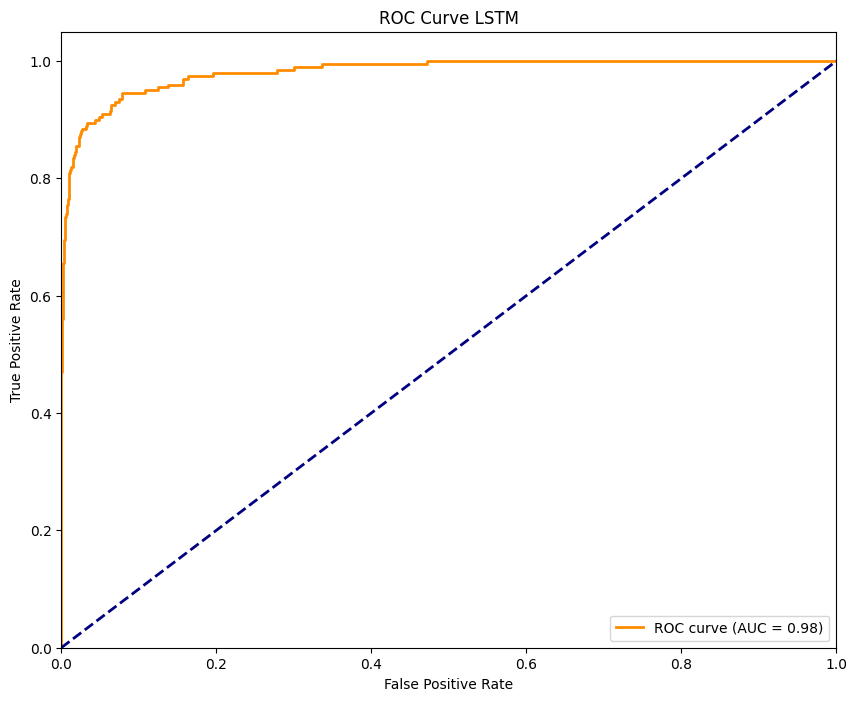

In [ ]:
X_train_lstm = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
lstm_model.fit(X_train_lstm, y_train)
probs = lstm_model.predict(X_test_lstm)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure(figsize=(10, 8))
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc[0]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve LSTM')
plt.legend(loc='lower right')
plt.show()

## **CNN**

In [ ]:
cnn_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
# Model summary
cnn_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 57)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 256)                 │          14,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 311,946 (1.19 MB)

 Trainable params: 311,946 (1.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the cnn_model
cnn_model.compile(loss='sparse_categorical_crossentropy', metrics=['accuracy'])
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Train the cnn_model
cnn_history = cnn_model.fit(X_train_cnn, y_train, epochs=200, validation_data=(X_test_cnn, y_test), batch_size=200,verbose=1)

Epoch 1/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1875 - loss: 2.1906 - val_accuracy: 0.3478 - val_loss: 1.7128
Epoch 2/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3686 - loss: 1.7227 - val_accuracy: 0.4239 - val_loss: 1.5226
Epoch 3/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4247 - loss: 1.5585 - val_accuracy: 0.5005 - val_loss: 1.3560
Epoch 4/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4820 - loss: 1.4249 - val_accuracy: 0.4444 - val_loss: 1.5007
Epoch 5/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5053 - loss: 1.3546 - val_accuracy: 0.5556 - val_loss: 1.1905
Epoch 6/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5371 - loss: 1.2684 - val_accuracy: 0.5911 - val_loss: 1.1050
Epoch 7/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5579 - loss: 1.2072 - val_accuracy: 0.6081 - val_loss: 1.0819
Epoch 8/200
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5886 - loss: 1.1643 - val_accuracy: 0.

<Figure size 2000x1500 with 0 Axes>

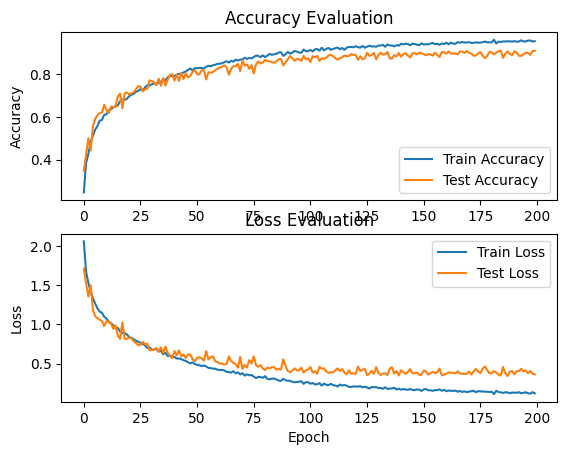

Training Loss: 0.12355489283800125
Training Accuracy: 0.9539539813995361
Test Loss: 0.3647507131099701
Test Accuracy: 0.9089089035987854


In [ ]:
plot_history(cnn_history)
train_loss = cnn_history.history['loss'][-1]
train_accuracy = cnn_history.history['accuracy'][-1]
val_loss = cnn_history.history['val_loss'][-1]
val_accuracy = cnn_history.history['val_accuracy'][-1]
print(f"Training Loss: {train_loss}")
print(f"Training Accuracy: {train_accuracy}")
print(f"Test Loss: {val_loss}")
print(f"Test Accuracy: {val_accuracy}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Confusion Matrix:
Confusion Matrix:
 [[188   0   6   0   0   1   4   0   0   1]
 [  0 194   1   0   1   2   0   0   0   2]
 [  9   1 178   3   0   4   0   2   0   2]
 [  1   0   1 183   1   1   2   3   3   5]
 [  0   0   0   4 187   0   1   3   3   2]
 [  7   4   3   0   0 184   0   1   0   1]
 [  3   0   0   3   4   0 182   0   3   5]
 [  1   0   6   5   5   1   0 180   2   0]
 [  4   0   6   2   2   2   0   3 180   1]
 [  4   0  20   7   0   2   4   1   1 160]]


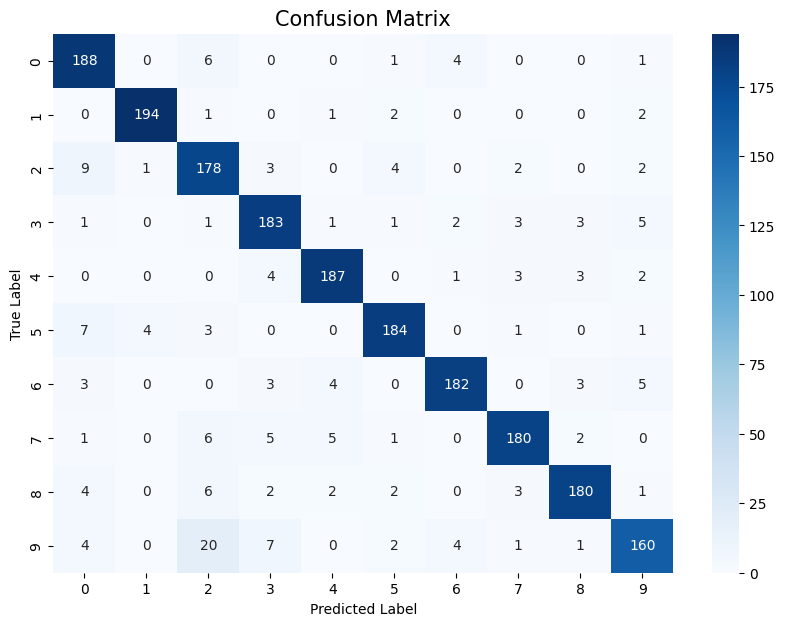

In [ ]:
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
# Make predictions
y_pred_cnn = cnn_model.predict(X_test_lstm)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)
print("Confusion Matrix:")
conf_matrix_cnn=confusion_matrix(y_test, y_pred_classes_cnn)
print("Confusion Matrix:\n", conf_matrix_cnn)
# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90       200
           1       0.97      0.97      0.97       200
           2       0.81      0.89      0.85       199
           3       0.88      0.92      0.90       200
           4       0.94      0.94      0.94       200
           5       0.93      0.92      0.93       200
           6       0.94      0.91      0.93       200
           7       0.93      0.90      0.92       200
           8       0.94      0.90      0.92       200
           9       0.89      0.80      0.85       199

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



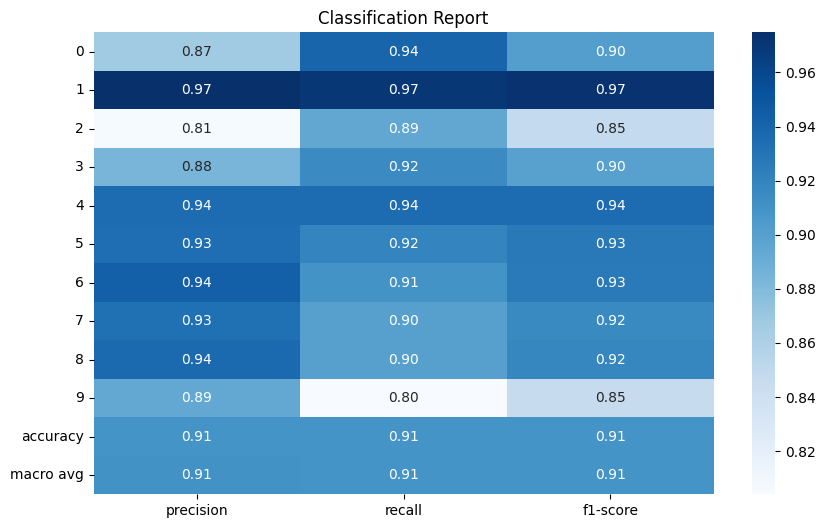

In [ ]:
print("Classification Report:\n", classification_report(y_test, y_pred_classes_cnn))
report_cnn = classification_report(y_test, y_pred_classes_cnn, output_dict=True)
# Plot the classification report
def plot_classification_report(report_cnn):
    report_df = pd.DataFrame(report_cnn).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()
plot_classification_report(report_cnn)

In [ ]:
cnn_accuracy = accuracy_score(y_test, y_pred_classes_cnn)
print(f"CNN Overall Accuracy: {cnn_accuracy:.2f}")

CNN Overall Accuracy: 0.91


188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8950 - loss: 0.2989
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


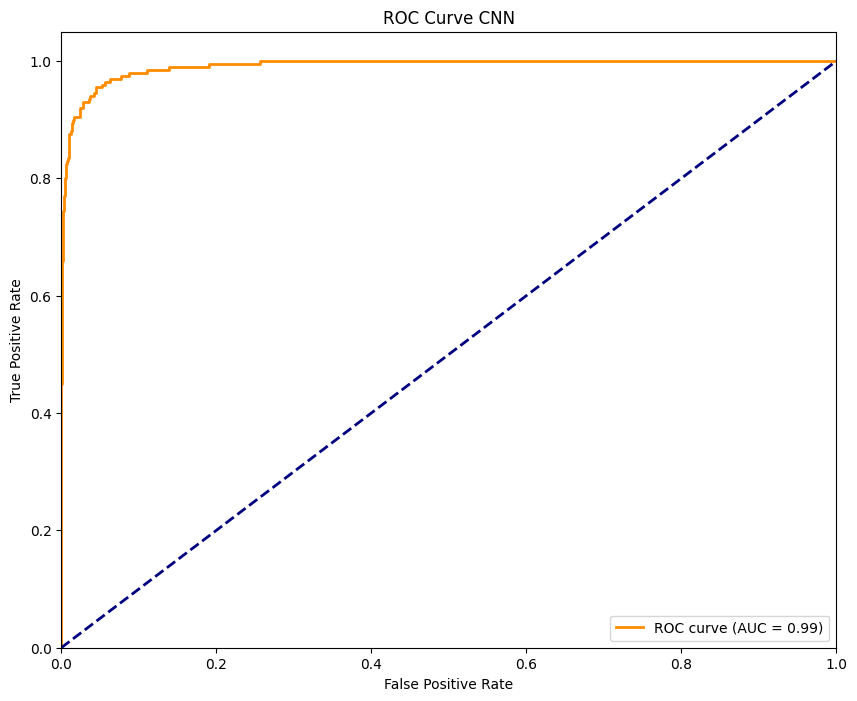

In [ ]:
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
cnn_model.fit(X_train_cnn, y_train)
probs = cnn_model.predict(X_test_lstm)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure(figsize=(10, 8))
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc[0]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve CNN')
plt.legend(loc='lower right')
plt.show()

## **XGB**

In [ ]:
# Instantiate the XGBClassifier with evaluation metrics
xgb_model = XGBClassifier(n_estimators=160, eval_metric=["merror", "mlogloss"], use_label_encoder=False)
# Fit the model and track the evaluation results on training and test sets
xgb_model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=True)
# Retrieve the evaluation results
results = xgb_model.evals_result()

[0]	validation_0-merror:0.24374	validation_0-mlogloss:1.61956	validation_1-merror:0.35485	validation_1-mlogloss:1.73387
[1]	validation_0-merror:0.18302	validation_0-mlogloss:1.30415	validation_1-merror:0.30430	validation_1-mlogloss:1.48411
[2]	validation_0-merror:0.14464	validation_0-mlogloss:1.08277	validation_1-merror:0.28328	validation_1-mlogloss:1.30733
[3]	validation_0-merror:0.12129	validation_0-mlogloss:0.92041	validation_1-merror:0.27477	validation_1-mlogloss:1.18293
[4]	validation_0-merror:0.10010	validation_0-mlogloss:0.79489	validation_1-merror:0.26026	validation_1-mlogloss:1.08775
[5]	validation_0-merror:0.08492	validation_0-mlogloss:0.69421	validation_1-merror:0.24975	validation_1-mlogloss:1.00627
[6]	validation_0-merror:0.07341	validation_0-mlogloss:0.60916	validation_1-merror:0.24274	validation_1-mlogloss:0.93887
[7]	validation_0-merror:0.06473	validation_0-mlogloss:0.54310	validation_1-merror:0.24074	validation_1-mlogloss:0.88633
[8]	validation_0-merror:0.05606	validati

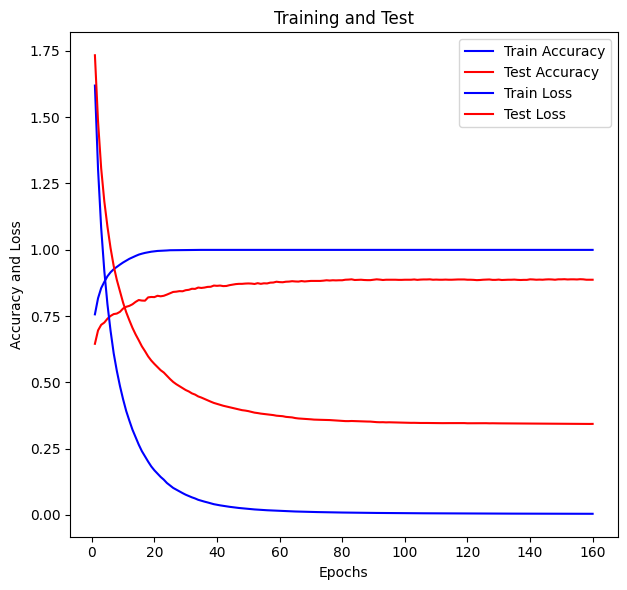

In [ ]:
train_error = results['validation_0']['merror']
test_error = results['validation_1']['merror']
train_logloss = results['validation_0']['mlogloss']
test_logloss = results['validation_1']['mlogloss']
epochs = range(1, len(train_error) + 1)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, np.array(1) - np.array(train_error), 'b-', label='Train Accuracy')
plt.plot(epochs, np.array(1) - np.array(test_error), 'r-', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.plot(epochs, train_logloss, 'b-', label='Train Loss')
plt.plot(epochs, test_logloss, 'r-', label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy and Loss')
plt.title('Training and Test')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
train_accuracy_xgb = accuracy_score(y_train, xgb_model.predict(X_train))
y_pred = xgb_model.predict(X_test)
test_accuracy_xgb = accuracy_score(y_test, y_pred) # Use y_pred for accuracy calculation
train_loss_xgb = log_loss(y_train, xgb_model.predict_proba(X_train))
test_loss_xgb = log_loss(y_test, xgb_model.predict_proba(X_test))
print(f"Training accuracy: {train_accuracy_xgb}")
print(f"Test accuracy: {test_accuracy_xgb}")
print(f"Training loss: {train_loss_xgb}")
print(f"Test loss: {test_loss_xgb}")

Training accuracy: 0.9994994994994995
Test accuracy: 0.8868868868868869
Training loss: 0.0037166590202654427
Test loss: 0.34294393022831104


Confusion Matrix:
 [[183   0   6   3   1   1   4   0   1   1]
 [  0 190   1   0   0   7   0   1   0   1]
 [  8   1 165   3   0   6   1   5   6   4]
 [  0   0   0 178   5   1   3   3   4   6]
 [  1   0   1   6 179   1   4   2   5   1]
 [  4   6   5   0   0 182   1   2   0   0]
 [  3   0   4   1   0   0 185   0   1   6]
 [  0   0   4   6   6   1   0 176   3   4]
 [  3   0   1   3   3   3   0   2 181   4]
 [  6   0  11   5   4   7   7   2   4 153]]


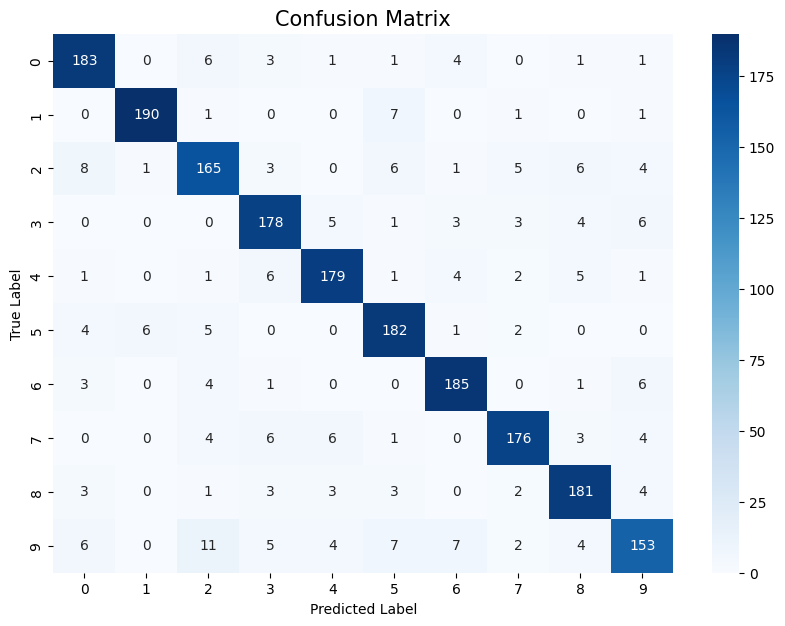

In [ ]:
# Reshape test data to match XGBoost input shape (2-dimensional)
X_test_xgb = X_test.reshape(X_test.shape[0], -1)
# Make predictions
y_pred_xgb = xgb_model.predict(X_test_xgb)
# Convert predictions to class labels
y_pred_classes_xgb = [round(value) for value in y_pred_xgb]
conf_matrix_xgb=confusion_matrix(y_test, y_pred_classes_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)
# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_xgb, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       200
           1       0.96      0.95      0.96       200
           2       0.83      0.83      0.83       199
           3       0.87      0.89      0.88       200
           4       0.90      0.90      0.90       200
           5       0.87      0.91      0.89       200
           6       0.90      0.93      0.91       200
           7       0.91      0.88      0.90       200
           8       0.88      0.91      0.89       200
           9       0.85      0.77      0.81       199

    accuracy                           0.89      1998
   macro avg       0.89      0.89      0.89      1998
weighted avg       0.89      0.89      0.89      1998



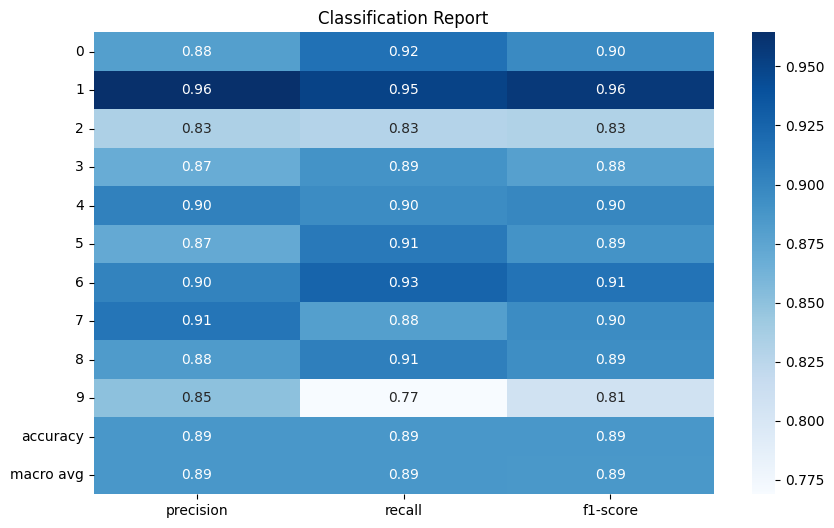

In [ ]:
# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred_classes_xgb))
report_xgb = classification_report(y_test, y_pred_classes_xgb, output_dict=True)
# Plot the classification report
def plot_classification_report(report_xgb):
    report_df = pd.DataFrame(report_xgb).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()

plot_classification_report(report_xgb)


In [ ]:
xgb_accuracy = accuracy_score(y_test, y_pred_classes_xgb)
print(f"XGB Overall Accuracy: {xgb_accuracy:.2f}")

XGB Overall Accuracy: 0.89


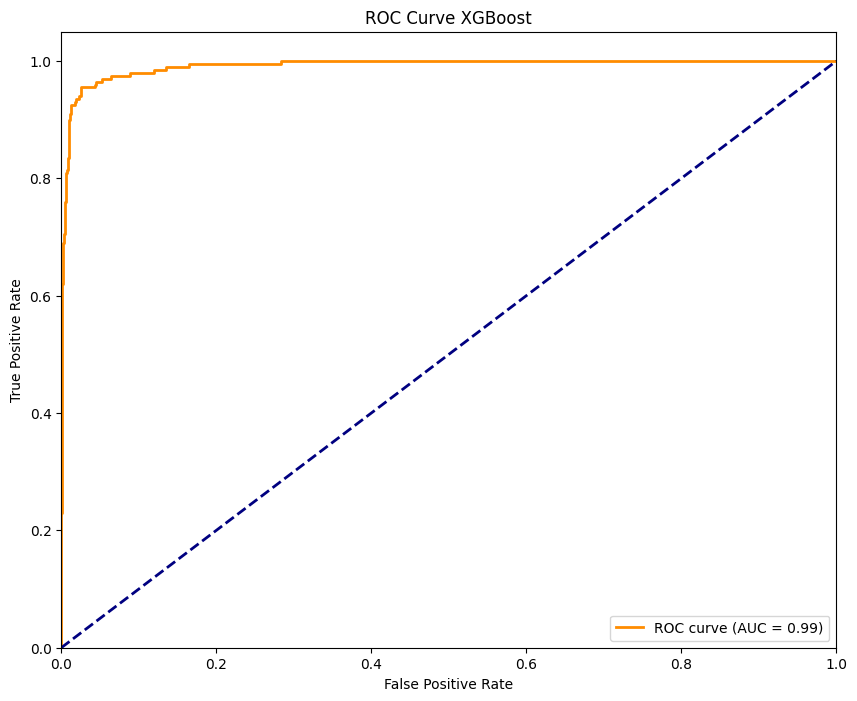

In [ ]:
X_train_xgb = X_train.reshape(X_train.shape[0], -1)
xgb_model.fit(X_train_xgb, y_train)
probs = xgb_model.predict_proba(X_test_xgb)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure(figsize=(10, 8))
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc[0]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve XGBoost')
plt.legend(loc='lower right')
plt.show()

## **Bi_LSTM**

In [ ]:
# Reshape X_train to be 3-dimensional
X_train_bilstm = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_bilstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# Define Bi-LSTM Model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train.shape[1], X_train.shape[1])))
bilstm_model.add(Dense(3000, activation='relu'))
bilstm_model.add(BatchNormalization())
bilstm_model.add(Dense(len(np.unique(y_train)), activation='softmax'))
# Compile the model
bilstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# Display model summary
bilstm_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │          62,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 3000)                │         387,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 3000)                │          12,000 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 10)                  │          30,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 491,474 (1.87 MB)

 Trainable params: 485,474 (1.85 MB)

 Non-trainable params: 6,000 (23.44 KB)

In [ ]:
# Fit the model
bilstm_history = bilstm_model.fit(X_train_bilstm, y_train, batch_size=200, epochs=100, validation_data=(X_test_bilstm,y_test), verbose=1)


Epoch 1/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.4343 - loss: 1.5525 - val_accuracy: 0.1537 - val_loss: 2.3186
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6849 - loss: 0.9540 - val_accuracy: 0.1091 - val_loss: 2.4585
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.7099 - loss: 0.8472 - val_accuracy: 0.1116 - val_loss: 2.4871
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.7214 - loss: 0.8106 - val_accuracy: 0.1361 - val_loss: 2.4909
Epoch 5/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7360 - loss: 0.7722 - val_accuracy: 0.1777 - val_loss: 2.4718
Epoch 6/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7455 - loss: 0.7312 - val_accuracy: 0.1887 - val_loss: 2.4255
Epoch 7/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7531 - loss: 0.7000 - val_accuracy: 0.1597 - val_loss: 2.3101
Epoch 8/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7722 - loss: 0.6603 - val_accuracy: 0.

<Figure size 2000x1500 with 0 Axes>

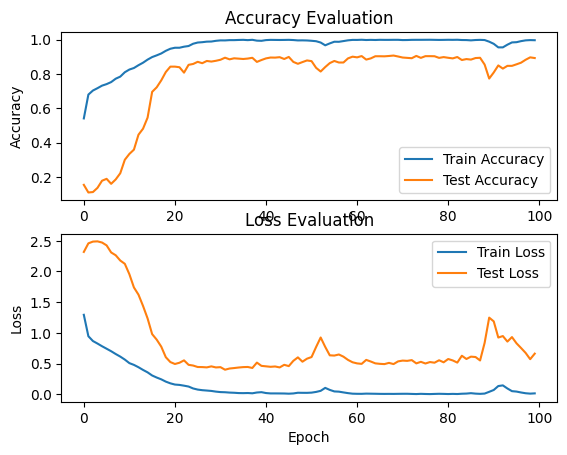

Training Accuracy: 0.9968301653862
Validation Accuracy: 0.8928928971290588
Training Loss: 0.013969715684652328
Validation Loss: 0.6614021062850952


In [ ]:
plot_history(bilstm_history)
train_accuracy_bilstm = bilstm_history.history['accuracy'][-1]
val_accuracy_bilstm = bilstm_history.history['val_accuracy'][-1]
train_loss_bilstm = bilstm_history.history['loss'][-1]
val_loss_bilstm = bilstm_history.history['val_loss'][-1]
print(f"Training Accuracy: {train_accuracy_bilstm}")
print(f"Validation Accuracy: {val_accuracy_bilstm}")
print(f"Training Loss: {train_loss_bilstm}")
print(f"Validation Loss: {val_loss_bilstm}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Confusion Matrix:
 [[181   0   8   2   0   3   1   0   2   3]
 [  0 194   1   0   1   3   0   0   0   1]
 [  2   1 178   1   2   6   0   3   0   6]
 [  0   0   7 166   6   1   4   3   3  10]
 [  0   0   1   2 186   0   0   3   6   2]
 [  7   7   0   0   1 183   0   1   1   0]
 [  3   0   1   0   4   0 187   0   1   4]
 [  0   0  11   5   6   2   0 171   3   2]
 [  3   0   9   0   4   2   0   1 180   1]
 [  1   2  18   1   6   3   4   2   4 158]]


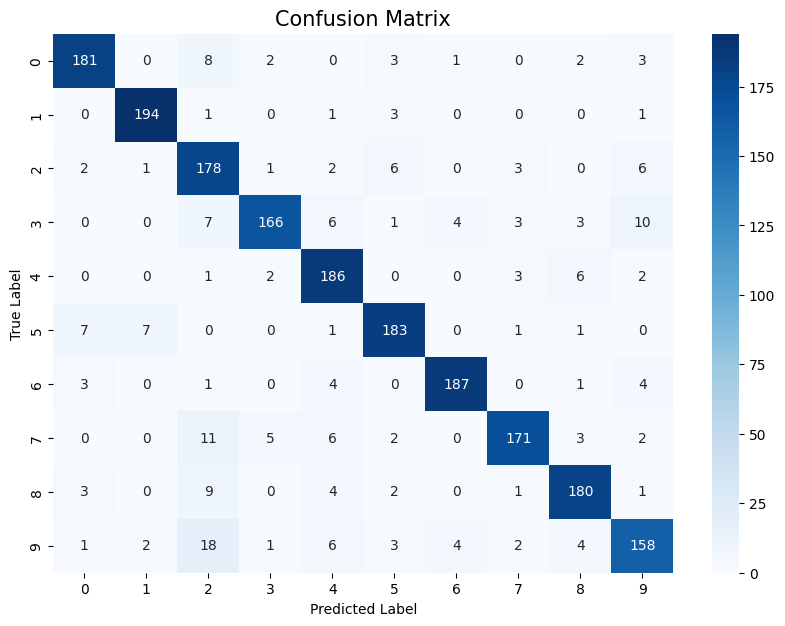

In [ ]:
# Reshape test data to match bilstmoost input shape (3-dimensional)
X_test_bilstm = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
# Make predictions
y_pred_bilstm = bilstm_model.predict(X_test_bilstm)
# Convert predictions to class labels
y_pred_classes_bilstm = np.argmax(y_pred_bilstm, axis=1)
conf_matrix_bilstm=confusion_matrix(y_test, y_pred_classes_bilstm)
print("Confusion Matrix:\n", conf_matrix_bilstm)
# Plot Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix_bilstm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix', fontsize=15)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.91      0.91       200
           1       0.95      0.97      0.96       200
           2       0.76      0.89      0.82       199
           3       0.94      0.83      0.88       200
           4       0.86      0.93      0.89       200
           5       0.90      0.92      0.91       200
           6       0.95      0.94      0.94       200
           7       0.93      0.85      0.89       200
           8       0.90      0.90      0.90       200
           9       0.84      0.79      0.82       199

    accuracy                           0.89      1998
   macro avg       0.90      0.89      0.89      1998
weighted avg       0.90      0.89      0.89      1998



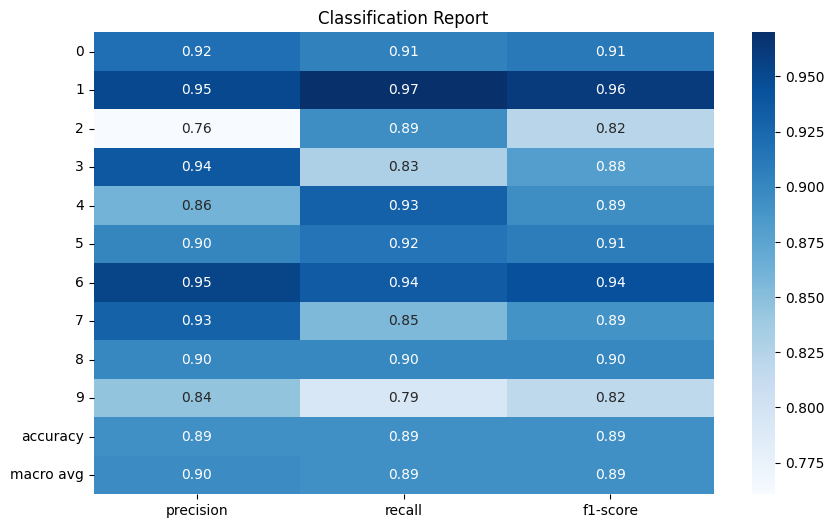

In [ ]:
# Generate classification report and confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred_classes_bilstm))
report_bilstm = classification_report(y_test, y_pred_classes_bilstm, output_dict=True)
# Plot the classification report
def plot_classification_report(report_bilstm):
    report_df = pd.DataFrame(report_bilstm).transpose()
    plt.figure(figsize=(10, 6))
    sns.heatmap(report_df.iloc[:-1, :].drop(columns=['support']), annot=True, cmap='Blues', fmt='.2f')
    plt.title('Classification Report')
    plt.show()

plot_classification_report(report_bilstm)

In [ ]:
bilstm_accuracy = accuracy_score(y_test, y_pred_classes_bilstm)
print(f"BI_LSTM Overall Accuracy: {bilstm_accuracy:.2f}")

BI_LSTM Overall Accuracy: 0.89


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.7919 - loss: 0.7223
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


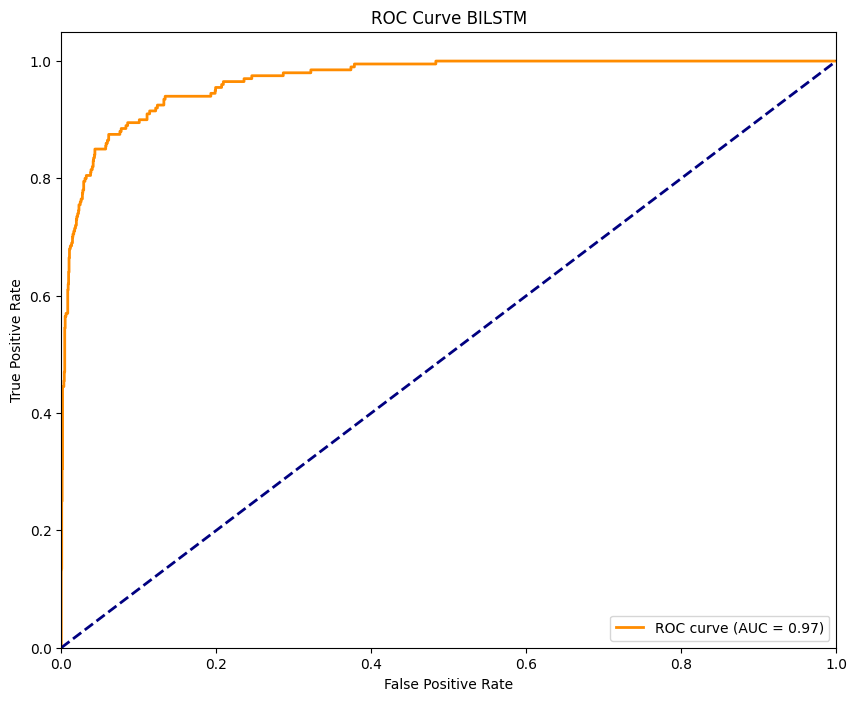

In [ ]:
bilstm_model.fit(X_train_bilstm, y_train)
probs = bilstm_model.predict(X_test_bilstm)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
plt.figure(figsize=(10, 8))
plt.plot(fpr[0], tpr[0], color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc[0]:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve BILSTM')
plt.legend(loc='lower right')
plt.show()

## **Model Evaluation**

In [ ]:
models = {
    'FCN_LSTM': fcn_lstm_accuracy*100,
    'RESNET': resnet_accuracy*100,
    'SVM': svm_accuracy*100,
    'FCN': fcn_accuracy*100,
    'LSTM': lstm_accuracy*100,
    'CNN': cnn_accuracy*100,
    'XGB': xgb_accuracy*100,
    'BI_LSTM': bilstm_accuracy*100,
}


for model, acc_score in models.items():
    print(f'{model} Accuracy: {acc_score:.2f}%')

# Choose the model with the highest accuracy score
best_model = max(models, key=models.get)
print(f'\nThe best model based on accuracy is: {best_model}')

FCN_LSTM Accuracy: 91.24%
RESNET Accuracy: 89.34%
SVM Accuracy: 90.74%
FCN Accuracy: 87.34%
LSTM Accuracy: 90.79%
CNN Accuracy: 90.89%
XGB Accuracy: 88.69%
BI_LSTM Accuracy: 89.29%

The best model based on accuracy is: FCN_LSTM


## **Barplot Model**

In [ ]:
model_ev = pd.DataFrame({'Model': ['FCN_LSTM','RESNET','SVM','FCN','LSTM','CNN','XGB','BI_LSTM'],
                        'Accuracy': [fcn_lstm_accuracy*100, resnet_accuracy*100, svm_accuracy*100,
                                      fcn_accuracy*100, lstm_accuracy*100,cnn_accuracy*100,
                                      xgb_accuracy*100,bilstm_accuracy*100 ]})

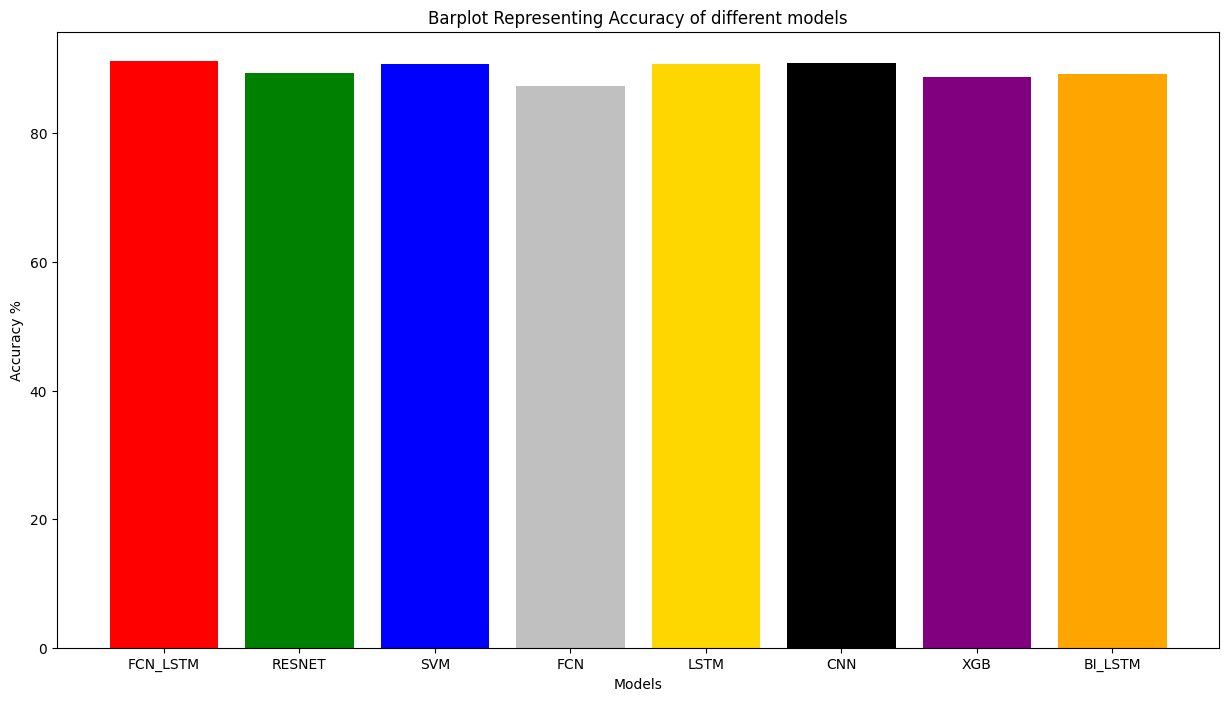

In [ ]:
colors = ['red', 'green', 'blue', 'silver', 'gold','black','purple','orange']
plt.figure(figsize=(15, 8), facecolor='w')
plt.title("Barplot Representing Accuracy of different models")
plt.ylabel("Accuracy %")
plt.xlabel("Models")
plt.bar(model_ev['Model'], model_ev['Accuracy'], color=colors)
plt.show()

## **ROC AUC**

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


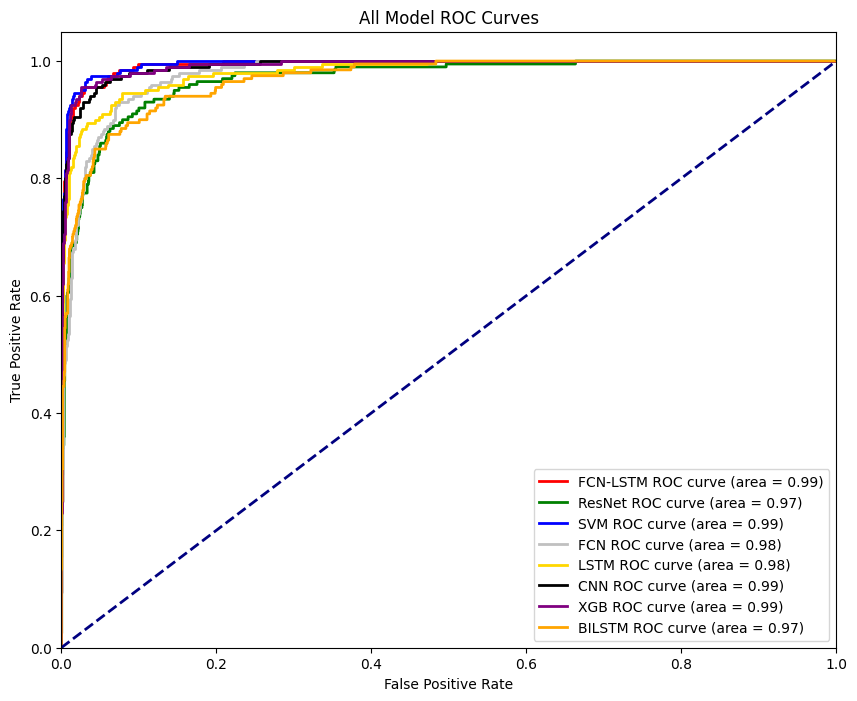

In [ ]:
def calculate_roc_auc(model, X_test, y_test, n_classes):
    # Use predict_proba to get probabilities for each class for models that support it
    if hasattr(model, "predict_proba"):
        y_pred = model.predict_proba(X_test)
    else:
        y_pred = model.predict(X_test)
        # Check if y_pred is 1D and convert to 2D if necessary
        if y_pred.ndim == 1:
            y_pred = y_pred[:, np.newaxis]
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return fpr, tpr, roc_auc
# One-hot encoding of y_test for ROC curve calculation
n_classes = len(np.unique(y_test))
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))
# Calculate ROC and AUC for FCN-LSTM
fpr_fcn_lstm, tpr_fcn_lstm, roc_auc_fcn_lstm = calculate_roc_auc(fcn_lstm_model, X_test_fcn_lstm, y_test, n_classes)
# Calculate ROC and AUC for ResNet
fpr_resnet, tpr_resnet, roc_auc_resnet = calculate_roc_auc(resnet_model, X_test, y_test, n_classes)
# Calculate ROC and AUC for SVM
fpr_svm, tpr_svm, roc_auc_svm = calculate_roc_auc(svm_best, X_test_svm, y_test, n_classes)
# Calculate ROC and AUC for FCN
fpr_fcn, tpr_fcn, roc_auc_fcn = calculate_roc_auc(fcn_model, X_test_fcn, y_test, n_classes)
# Calculate ROC and AUC for LSTM
fpr_lstm, tpr_lstm, roc_auc_lstm = calculate_roc_auc(lstm_model, X_test_lstm, y_test, n_classes)
# Calculate ROC and AUC for CNN
fpr_cnn, tpr_cnn, roc_auc_cnn = calculate_roc_auc(cnn_model, X_test_cnn, y_test, n_classes)
# Calculate ROC and AUC for XGB
fpr_xgb, tpr_xgb, roc_auc_xgb = calculate_roc_auc(xgb_model, X_test_xgb, y_test, n_classes)
# Calculate ROC and AUC for BILSTM
fpr_bilstm, tpr_bilstm, roc_auc_bilstm = calculate_roc_auc(bilstm_model, X_test_bilstm, y_test, n_classes)
# Plot combined ROC curves
plt.figure(figsize=(10, 8))
# FCN-LSTM ROC curve for class 0
plt.plot(fpr_fcn_lstm[0], tpr_fcn_lstm[0], color='red', lw=2, label='FCN-LSTM ROC curve (area = %0.2f)' % roc_auc_fcn_lstm[0])
# ResNet ROC curve for class 0
plt.plot(fpr_resnet[0], tpr_resnet[0], color='green', lw=2, label='ResNet ROC curve (area = %0.2f)' % roc_auc_resnet[0])
# SVM ROC curve for class 0
plt.plot(fpr_svm[0], tpr_svm[0], color='blue', lw=2, label='SVM ROC curve (area = %0.2f)' % roc_auc_svm[0])
# FCN ROC curve for class 0
plt.plot(fpr_fcn[0], tpr_fcn[0], color='silver', lw=2, label='FCN ROC curve (area = %0.2f)' % roc_auc_fcn[0])
# LSTM ROC curve for class 0
plt.plot(fpr_lstm[0], tpr_lstm[0], color='gold', lw=2, label='LSTM ROC curve (area = %0.2f)' % roc_auc_lstm[0])
# CNN ROC curve for class 0
plt.plot(fpr_cnn[0], tpr_cnn[0], color='black', lw=2, label='CNN ROC curve (area = %0.2f)' % roc_auc_cnn[0])
# XGB ROC curve for class 0
plt.plot(fpr_xgb[0], tpr_xgb[0], color='purple', lw=2, label='XGB ROC curve (area = %0.2f)' % roc_auc_xgb[0])
# BILSTM ROC curve for class 0
plt.plot(fpr_bilstm[0], tpr_bilstm[0], color='orange', lw=2, label='BILSTM ROC curve (area = %0.2f)' % roc_auc_bilstm[0])
# Add a diagonal line for reference (random classifier)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All Model ROC Curves')
plt.legend(loc="lower right")
plt.show()